In [2]:
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import lightgbm as lgb
import os
from pathlib import Path
import os, numpy as np
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
from subprocess import check_output, STDOUT
from itertools import zip_longest
from glob import glob
import pickle
from statsmodels.stats.multitest import multipletests
FA_figure_dir='/data/xzhao14/FA_figures'

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import rankdata
import umap
import matplotlib.pyplot as plt
import mpmath as mp

# Increase mpmath precision to capture extremely small p-values
mp.mp.dps = 100

def upper_f_pvalue(f_stat, df1, df2):
    """
    Compute P(F(df1, df2) > f_stat) via the regularized upper incomplete beta:
      P = I_z(a, b) from z to 1,
    where a = df1/2, b = df2/2, and z = (df1 * f_stat) / (df1 * f_stat + df2).
    """
    a = mp.mpf(df1) / 2
    b = mp.mpf(df2) / 2
    z = (mp.mpf(df1) * mp.mpf(f_stat)) / (mp.mpf(df1) * mp.mpf(f_stat) + mp.mpf(df2))
    return mp.betainc(a, b, z, 1, regularized=True)

def analyze_udip_and_csf(udip_csv, csf_csv, output_csv, umap_fig):
    # --- load & merge ---
    udip = pd.read_csv(udip_csv)
    csf  = pd.read_csv(csf_csv)
    udip.columns = udip.columns.astype(str)
    csf.columns  = csf.columns.astype(str)
    merged = pd.merge(
        udip, csf,
        left_on=udip.columns[0],
        right_on=csf.columns[0]
    )

    # Prepare X and Y
    X = merged[udip.columns[2:]].values
    Y = merged[csf.columns[1:]].values
    m = Y.shape[1]  # number of tests for Bonferroni

    results = []
    for i, region in enumerate(csf.columns[1:]):
        y = Y[:, i]

        # 1) Compute R²
        lr = LinearRegression().fit(X, y)
        r2 = r2_score(y, lr.predict(X))

        # 2) Fit OLS to get F-statistic
        X_sm  = sm.add_constant(X)
        model = sm.OLS(y, X_sm).fit()
        f_stat = float(model.fvalue)
        df1, df2 = int(model.df_model), int(model.df_resid)

        # 3) Compute high-precision p-value
        p_mp = upper_f_pvalue(f_stat, df1, df2)
        print(p_mp)
        # 4) Format output: if p_mp is zero at this precision, report "<1e-<precision>"
        if p_mp == 0:
            raw_str = f"<1e-{mp.mp.dps}"
            bonf_str = raw_str
        else:
            raw_str  = mp.nstr(p_mp, 20)                    # 20 significant digits
            bonf_str = mp.nstr(min(p_mp * m, mp.mpf(1)), 20)

        results.append({
            'Brain Region':        region,
            'R2 Score':            f"{r2:.4f}",
            'Raw P Value':         raw_str,
            'Bonferroni P Value':  bonf_str
        })

    # Save results
    pd.DataFrame(results).to_csv(output_csv, index=False)

    # --- UMAP plotting ---
    csf_mean    = Y.mean(axis=1)
    csf_percent = rankdata(csf_mean) / len(csf_mean) * 100
    emb = umap.UMAP(n_components=2, random_state=42).fit_transform(X)

    fig, ax = plt.subplots(figsize=(10, 8))
    sc = ax.scatter(emb[:,0], emb[:,1], c=csf_percent, cmap='hot', s=2)
    cbar = plt.colorbar(sc, ax=ax, fraction=0.02, pad=0.04)
    cbar.set_label('CSF percentile', rotation=270, labelpad=15)
    cbar.set_ticks([0, 50, 100])
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(umap_fig, dpi=300)
    plt.close()

# example call
analyze_udip_and_csf(
    udip_csv='/data/xzhao14/FA_all_phenotype.csv',
    csf_csv='/data/xzhao14/FA_value.csv',
    output_csv='/data/xzhao14/outputs/FA_r2_scores.csv',
    umap_fig='/data/xzhao14/outputs/udip_umap.pdf'
)

9.317978484199206433055213975581436404302874963222328704593259135202178713717342942664692374023263474e-105
0.0
9.317978484199206433055213975581436404302874963222328704593259135202178713717342942664692374023263474e-105
-9.317978484199206433055213975581436404302874963222328704593259135202178713717342942664692374023263474e-105
9.317978484199206433055213975581436404302874963222328704593259135202178713717342942664692374023263474e-105
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.317978484199206433055213975581436404302874963222328704593259135202178713717342942664692374023263474e-105
0.0
0.0
0.0
9.317978484199206433055213975581436404302874963222328704593259135202178713717342942664692374023263474e-105
0.0
-9.317978484199206433055213975581436404302874963222328704593259135202178713717342942664692374023263474e-105
0.0
9.317978484199206433055213975581436404302874963222328704593259135202178713717342942664692374023263474e-105
0.0
0.0
0.0
-9.317978484199206433055213975581436404302874963222328704593259135202178713717

/data/xzhao14/miniconda3/envs/post_gwas/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(26285, 179)


/data/xzhao14/miniconda3/envs/post_gwas/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


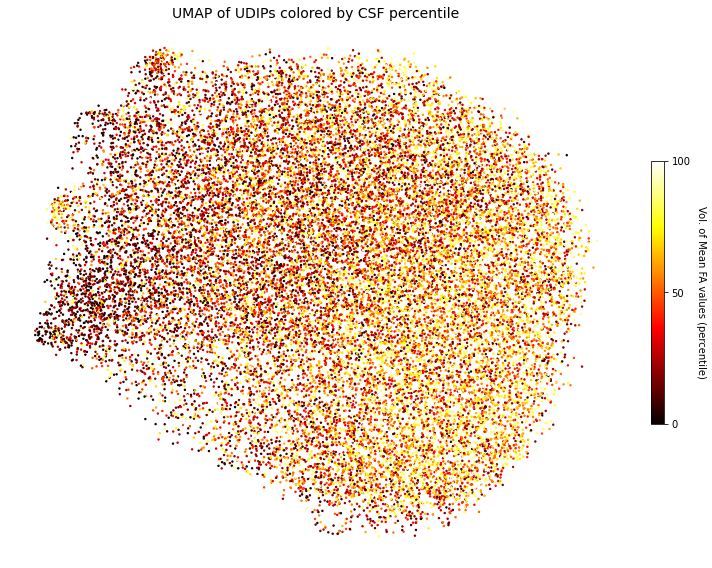

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from decimal import Decimal, getcontext
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import decimal
from scipy.stats import f
from scipy.stats import rankdata

def analyze_udip_and_csf(udip_csv, csf_csv, output_r2_csv, umap_fig_path):
    """
    Perform multivariate regression between UDIP features and CSF volumes,
    compute R² scores and overall p-values, and visualize UMAP embedding 
    colored by percentile-ranked mean CSF. Includes Bonferroni correction.

    Parameters:
    - udip_csv: str, path to the UDIP CSV file
    - csf_csv: str, path to the CSF percentile CSV file
    - output_r2_csv: str, path to save R² and p-values
    - umap_fig_path: str, path to save UMAP figure
    """
    
    # Load input CSVs
    udip_df = pd.read_csv(udip_csv)
    csf_df = pd.read_csv(csf_csv)

    # Ensure consistent column naming
    udip_df.columns = udip_df.columns.astype(str)
    csf_df.columns = csf_df.columns.astype(str)

    # Merge on subject ID (first column of each file)
    merged_df = pd.merge(udip_df, csf_df, left_on=udip_df.columns[0], right_on=csf_df.columns[0])
    print(merged_df.shape)

    # Extract matrices
    feature_cols = udip_df.columns[2:]  # skip ID columns
    csf_cols = csf_df.columns[1:]       # skip ID column

    X = merged_df[feature_cols].values
    Y = merged_df[csf_cols].values

    # Compute R² and p-value for each brain region
    getcontext().prec = 200  # set high precision for Decimal

    results = []
    raw_pvals = []

    for i, region in enumerate(csf_cols):
        y = Y[:, i]

        # R² from sklearn
        lr = LinearRegression()
        lr.fit(X, y)
        y_pred = lr.predict(X)
        r2 = r2_score(y, y_pred)

        # statsmodels fit
        X_sm = sm.add_constant(X)
        model = sm.OLS(y, X_sm).fit()

        # manually compute the right tail of the F distribution (i.e., p-value)
        f_stat = float(model.fvalue)
        df1 = int(model.df_model)
        df2 = int(model.df_resid)

        # compute p-value using scipy
        pval_float = f.sf(f_stat, df1, df2)

        # convert to Decimal to preserve tiny values
        pval_decimal = Decimal(str(pval_float))

        raw_pvals.append(pval_decimal)

        results.append({
            'Brain Region': region,
            'R2 Score': round(r2, 4),
            'Raw P Value': pval_decimal
        })

    # Create DataFrame
    results_df = pd.DataFrame(results)

    # Bonferroni correction
    num_tests = len(results_df)
    results_df['Bonferroni P Value'] = results_df['Raw P Value'].apply(lambda p: min(p * num_tests, 1.0))

    # Format p-values and R² for clarity
    results_df['R2 Score'] = results_df['R2 Score'].apply(lambda x: f"{x:.4f}")
    #results_df['Raw P Value'] = results_df['Raw P Value'].apply(lambda x: format(x, '.15e'))
    #results_df['Bonferroni P Value'] = results_df['Bonferroni P Value'].apply(lambda x: format(x, '.15e'))
    getcontext().prec = 200

    results_df['Raw P Value'] = results_df['Raw P Value'].apply(lambda x: format(Decimal(str(x)), '.15e'))
    results_df['Bonferroni P Value'] = results_df['Bonferroni P Value'].apply(lambda x: format(Decimal(str(x)), '.15e'))
    # Save results to CSV
    results_df.to_csv(output_r2_csv, index=False)

    # Compute mean CSF and convert to percentile
    csf_mean = Y.mean(axis=1)
    csf_percentile = rankdata(csf_mean, method='average') / len(csf_mean) * 100

    # UMAP dimensionality reduction
    # Fit UMAP to reduce dimensionality to 2D
# Fit UMAP to reduce high-dimensional data to 2D
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(X)  # X: your feature matrix

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Use 'hot' colormap: dark (low values) -> yellow/white (high values)
    sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=csf_percentile, cmap='hot', s=2)

    # Add vertical colorbar
    cbar = plt.colorbar(sc, ax=ax, fraction=0.02, pad=0.04)
    cbar.set_label('Vol. of Mean FA values (percentile)', rotation=270, labelpad=15)  # Label on the right
    cbar.ax.tick_params(labelsize=10)
    cbar.set_ticks([0, 50, 100])  # Customize tick marks

    # Remove axis lines and ticks
    ax.set_title('UMAP of UDIPs colored by CSF percentile', fontsize=14)
    ax.set_axis_off()

    # Optimize layout and save
    plt.tight_layout()
    plt.savefig(umap_fig_path, dpi=300)
    plt.show()
plt.close()
### #
analyze_udip_and_csf(
    udip_csv='/data/xzhao14/FA_all_phenotype.csv',
    csf_csv='/data/xzhao14/FA_value.csv',
    output_r2_csv='/data/xzhao14/outputs/FA_r2_scores.csv',
    umap_fig_path='/data/xzhao14/outputs/udip_umap.pdf'
)

In [ ]:
## calculate the mean FA R2 and association between
import pandas as pd
import numpy as np
FA_r2=pd.read_csv('/data/xzhao14/outputs/FA_r2_scores.csv')
np.mean(FA_r2['R2 Score'])

In [ ]:
## visualization of the mean FA in different brain regions
import pandas as pd
import matplotlib.pyplot as plt

### Using the UDIP-FA to predicted the age and sex 
- using the feature matrix to predicted the age and sex
- using the cluster methods to cluster the 128 feature 
- using five fold cross-validation strategy

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, SVC
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, roc_auc_score, accuracy_score, classification_report, roc_curve
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
def cluster_features(X, max_clusters=10, visualize=True, random_state=42,save_dir="/data/xzhao14/outputs"):
    """
    Cluster the feature matrix and visualize the clustering results.

    Parameters:
    - X: np.array, shape (n_samples, n_features), the original feature matrix.
    - max_clusters: int, maximum number of clusters to test (used to determine optimal number of clusters).
    - visualize: bool, whether to visualize the clustering heatmap.
    - random_state: int, random seed for reproducibility.

    Returns:
    - labels: cluster labels, shape (n_features,).
    - best_k: optimal number of clusters.
    """

    # Transpose matrix to cluster features
    X_T = X.T

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_T)

    # Automatically determine the optimal number of clusters using silhouette score
    best_k = 2
    best_score = -1
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_score = score
            best_k = k

    # Perform final clustering with optimal number of clusters
    kmeans_final = KMeans(n_clusters=best_k, random_state=random_state)
    final_labels = kmeans_final.fit_predict(X_scaled)

    # Visualize clustering results
    if visualize:
        sorted_idx = np.argsort(final_labels)
        sorted_X = X_scaled[sorted_idx, :]
        sorted_labels = final_labels[sorted_idx]

        plt.figure(figsize=(10, 8))
        sns.heatmap(sorted_X, cmap='vlag', cbar=True, xticklabels=False, yticklabels=False)
        plt.title(f'Feature Clustering Heatmap (k={best_k})', fontsize=14)
        plt.xlabel('Samples', fontsize=12)
        plt.ylabel('Clustered Features', fontsize=12)
        plt.tight_layout()
        plt.show()
        #plt.savefig("feature_clustering_heatmap.pdf")
        plt.savefig(os.path.join(save_dir, "feature_clustering_heatmap.pdf"))
        plt.close()

    return final_labels, best_k


def predict_age_gender(X, age, gender, n_splits=5, random_state=42, save_dir="/data/xzhao14/outputs"):
    """
    Perform regression (age) and classification (gender) prediction from feature matrix using 5-fold cross validation.

    Parameters:
    - X: np.array, shape (n_samples, n_features), feature matrix.
    - age: np.array, shape (n_samples,), target ages.
    - gender: np.array, shape (n_samples,), binary gender labels (0/1).
    - n_splits: int, number of cross validation folds.
    - random_state: int, random seed for reproducibility.
    - save_dir: str, directory to save output figures.

    Returns:
    - age_metrics: dict, containing MAE and Pearson r (mean and std) for SVR and ElasticNet.
    - gender_metrics: dict, containing Accuracy, AUC (mean and std), and classification report for SVC.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Lists to store fold-wise metrics
    svr_mae_list, svr_pearson_list = [], []
    enet_mae_list, enet_pearson_list = [], []
    svc_auc_list, svc_acc_list = [], []

    # To aggregate predictions for plotting
    agg_age_true_svr, agg_age_pred_svr = [], []
    agg_age_true_enet, agg_age_pred_enet = [], []
    agg_gender_true, agg_gender_prob, agg_gender_pred = [], [], []
    
    # For ROC curve: store fpr and tpr for each fold
    svc_fpr_list, svc_tpr_list = [], []

    # Set up 5-fold cross validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for train_index, test_index in kf.split(X):
        # Split fold data
        X_train, X_test = X[train_index], X[test_index]
        age_train, age_test = age[train_index], age[test_index]
        gender_train, gender_test = gender[train_index], gender[test_index]
        
        # Standardize features using training data only
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # --- Age prediction using SVR ---
        svr = SVR()
        svr.fit(X_train_scaled, age_train)
        age_pred_svr = svr.predict(X_test_scaled)
        mae_svr = mean_absolute_error(age_test, age_pred_svr)
        pearson_r_svr, _ = pearsonr(age_test, age_pred_svr)
        
        svr_mae_list.append(mae_svr)
        svr_pearson_list.append(pearson_r_svr)
        agg_age_true_svr.extend(age_test)
        agg_age_pred_svr.extend(age_pred_svr)
        
        # --- Age prediction using ElasticNet ---
        enet = ElasticNet(random_state=random_state)
        enet.fit(X_train_scaled, age_train)
        age_pred_enet = enet.predict(X_test_scaled)
        mae_enet = mean_absolute_error(age_test, age_pred_enet)
        pearson_r_enet, _ = pearsonr(age_test, age_pred_enet)
        
        enet_mae_list.append(mae_enet)
        enet_pearson_list.append(pearson_r_enet)
        agg_age_true_enet.extend(age_test)
        agg_age_pred_enet.extend(age_pred_enet)
        
        # --- Gender prediction using SVC ---
        svc = SVC(probability=True, random_state=random_state)
        svc.fit(X_train_scaled, gender_train)
        gender_pred = svc.predict(X_test_scaled)
        gender_prob = svc.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(gender_test, gender_prob)
        acc = accuracy_score(gender_test, gender_pred)
        
        svc_auc_list.append(auc)
        svc_acc_list.append(acc)
        agg_gender_true.extend(gender_test)
        agg_gender_prob.extend(gender_prob)
        agg_gender_pred.extend(gender_pred)
        
        # Compute ROC curve for this fold and store it
        fpr, tpr, _ = roc_curve(gender_test, gender_prob)
        svc_fpr_list.append(fpr)
        svc_tpr_list.append(tpr)
    
    # Compute mean and standard deviation for regression metrics
    svr_mae_mean, svr_mae_std = np.mean(svr_mae_list), np.std(svr_mae_list)
    svr_pearson_mean, svr_pearson_std = np.mean(svr_pearson_list), np.std(svr_pearson_list)
    enet_mae_mean, enet_mae_std = np.mean(enet_mae_list), np.std(enet_mae_list)
    enet_pearson_mean, enet_pearson_std = np.mean(enet_pearson_list), np.std(enet_pearson_list)
    
    # Compute mean and std for classification metrics
    svc_auc_mean, svc_auc_std = np.mean(svc_auc_list), np.std(svc_auc_list)
    svc_acc_mean, svc_acc_std = np.mean(svc_acc_list), np.std(svc_acc_list)
    
    # ----- Plotting Regression Results for SVR -----
    plt.figure(figsize=(6, 6))
    plt.scatter(agg_age_true_svr, agg_age_pred_svr, alpha=0.6, label='SVR Predictions')
    x_min, x_max = min(agg_age_true_svr), max(agg_age_true_svr)
    plt.plot([x_min, x_max], [x_min, x_max], 'r--', label='Ideal')
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.title('SVR Age Prediction (5-Fold CV)')
    plt.legend()
    plt.grid(True)
    annotation_text = (f"MAE = {svr_mae_mean:.2f} ± {svr_mae_std:.2f}\n"
                       f"Pearson r = {svr_pearson_mean:.2f} ± {svr_pearson_std:.2f}")
    plt.annotate(annotation_text, xy=(0.05, 0.95), xycoords='axes fraction',
                 fontsize=10, verticalalignment='top')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "svr_age_prediction_cv.pdf"))
    plt.close()
    
    # ----- Plotting Regression Results for ElasticNet -----
    plt.figure(figsize=(6, 6))
    plt.scatter(agg_age_true_enet, agg_age_pred_enet, alpha=0.6, label='ElasticNet Predictions')
    x_min, x_max = min(agg_age_true_enet), max(agg_age_true_enet)
    plt.plot([x_min, x_max], [x_min, x_max], 'r--', label='Ideal')
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.title('ElasticNet Age Prediction (5-Fold CV)')
    plt.legend()
    plt.grid(True)
    annotation_text = (f"MAE = {enet_mae_mean:.2f} ± {enet_mae_std:.2f}\n"
                       f"Pearson r = {enet_pearson_mean:.2f} ± {enet_pearson_std:.2f}")
    plt.annotate(annotation_text, xy=(0.05, 0.95), xycoords='axes fraction',
                 fontsize=10, verticalalignment='top')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "elasticnet_age_prediction_cv.pdf"))
    plt.close()
    # ----- Plotting Mean ROC Curve for SVC -----
    # Create a common FPR axis and interpolate each fold's TPR to it
    mean_fpr = np.linspace(0, 1, 100)
    tprs_interp = []
    for fpr, tpr in zip(svc_fpr_list, svc_tpr_list):
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs_interp.append(interp_tpr)
    tprs_interp = np.array(tprs_interp)
    mean_tpr = tprs_interp.mean(axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = tprs_interp.std(axis=0)
    
    plt.figure(figsize=(6, 6))
    plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {svc_auc_mean:.2f} ± {svc_auc_std:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey',
                     alpha=0.3, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve for Gender Classification (5-Fold CV)')
    plt.legend(loc="lower right")
    plt.grid(True)
    annotation_text = f"Accuracy = {svc_acc_mean:.2f} ± {svc_acc_std:.2f}"
    plt.annotate(annotation_text, xy=(0.05, 0.05), xycoords='axes fraction', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "svc_gender_roc_cv.pdf"))
    plt.close()
    
    # Prepare metrics dictionaries
    age_metrics = {
        'SVR': {'MAE_mean': svr_mae_mean, 'MAE_std': svr_mae_std,
                'Pearson_r_mean': svr_pearson_mean, 'Pearson_r_std': svr_pearson_std},
        'ElasticNet': {'MAE_mean': enet_mae_mean, 'MAE_std': enet_mae_std,
                       'Pearson_r_mean': enet_pearson_mean, 'Pearson_r_std': enet_pearson_std}
    }
    
    gender_metrics = {
        'SVC': {'Accuracy_mean': svc_acc_mean, 'Accuracy_std': svc_acc_std,
                'AUC_mean': svc_auc_mean, 'AUC_std': svc_auc_std,
                'Classification_Report': classification_report(np.array(agg_gender_true), 
                                                               np.array(agg_gender_pred), output_dict=True)}
    }
    
    return age_metrics, gender_metrics

# Example Usage:
data_path='/data/xzhao14/FA_all_phenotype.csv'
covar_file = pd.read_csv('/data/xzhao14/PRS_covar.csv',delim_whitespace=True)
phenotype_file = pd.read_csv(data_path)
common_iids = phenotype_file['IID'].isin(covar_file['IID'])
sample_ids = phenotype_file.iloc[:, :2]  # First two columns are IDs
features = phenotype_file.iloc[:, 2:].values  # Remaining columns are features
labels, optimal_k = cluster_features(features, max_clusters=40, visualize=True,save_dir='/data/xzhao14/FA_age_prediction')
# phenotype_file = phenotype_file[common_iids]
# # reorder the phenotype files ##
# covar_file = covar_file.set_index('IID')
# phenotype_file = phenotype_file.set_index('IID')
# covar_file = covar_file.loc[phenotype_file.index]
# covar_file = covar_file.reset_index()
# phenotype_file = phenotype_file.reset_index()
# sex=covar_file['SEX'].values
# age=covar_file['AGE'].values
# features = phenotype_file.iloc[:, 2:].values
# age_metrics, gender_metrics = predict_age_gender(features, age, sex,save_dir='/data/xzhao14/FA_age_prediction')

## PerD result visualization 
- For different tissue(include CSF,GM and WM)
- For different regions of WM

In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import nibabel as nib
import pandas as pd
from nilearn import datasets
from nilearn import plotting


def load_nifti(file_path):
    """Load a NIfTI file and return the nibabel image object"""
    return nib.load(file_path)


def load_region_info(txt_file):
    """
    Load brain region info file, assuming it contains three columns:
      Column 1: numerical label in the segmentation template
      Column 2: abbreviated brain region name
      Column 3: full brain region name
    """
    df = pd.read_csv(txt_file, sep='\t', header=None, names=['value', 'abbr', 'full_name'], index_col=None)
    print(df)
    return df


def compute_ks_statistic(tmap_data, seg_data, region_df, top_n_ratio=0.1):
    """
    Compute Kolmogorov-Smirnov (K-S) statistic for each brain region
    and return the results sorted by statistic value.
    """
    tmap_data = np.abs(tmap_data)
    
    # Retain only non-zero regions in mask
    masked_tmap = tmap_data[seg_data > 0]
    
    # Total number of voxels in the mask
    total_voxels = masked_tmap.size
    
    # Number of top_n voxels
    top_n = int(total_voxels * top_n_ratio)
    
    # Sort t-values in descending order and get top_n indices
    sorted_indices = np.argsort(-masked_tmap)
    top_n_indices = sorted_indices[:top_n]
    
    total_top_n_voxels = len(top_n_indices)
    
    ks_stats = {}
    
    # Iterate over each unique brain region
    unique_regions = np.unique(seg_data)
    for reg_val in unique_regions:
        if reg_val == 0:
            continue
        
        mask = seg_data == reg_val
        region_voxels = np.sum(mask)
        if region_voxels == 0:
            continue
        
        region_t_values = tmap_data[mask]
        
        region_top_n_voxels = np.sum(region_t_values >= masked_tmap[top_n_indices[-1]])
        
        ks_stat = (region_top_n_voxels / region_voxels) - (total_top_n_voxels / total_voxels)
        ks_stats[reg_val] = ks_stat
    
    # Match region names and sort
    ks_results = []
    for reg_val, ks_stat in ks_stats.items():
        row = region_df[region_df['value'] == reg_val]
        region_name = row.iloc[0]['abbr'] if not row.empty else f"Region {reg_val}"
        ks_results.append((reg_val, region_name, ks_stat))
    
    ks_results.sort(key=lambda x: x[2], reverse=True)
    
    return ks_results


def generate_ks_nifti(ks_results, seg_data, seg_img):
    """
    Generate a new NIfTI file where voxel values in each region 
    are set to the region's K-S statistic
    """
    ks_map = np.zeros_like(seg_data)

    for reg_val, _, ks_stat in ks_results:
        ks_map[seg_data == reg_val] = ks_stat

    return nib.Nifti1Image(ks_map, affine=seg_img.affine, header=seg_img.header)


def visualize_top_ks_regions(ks_results, seg_data, seg_img):
    """
    Visualize the top 3 brain regions with the highest K-S statistics
    """
    top_3_regions = ks_results[:3]
    top_3_map = np.zeros_like(seg_data)
    for reg_val, _, ks_stat in top_3_regions:
        top_3_map[seg_data == reg_val] = ks_stat

    top_3_img = nib.Nifti1Image(top_3_map, affine=seg_img.affine, header=seg_img.header)

    # You can uncomment this to use a white matter atlas background
    # jhu_wm = datasets.fetch_atlas_jhu_dti_81()
    # wm_bg_img = nib.load(jhu_wm.maps)

    view = plotting.view_img(
        top_3_img,
        # bg_img=wm_bg_img,
        symmetric_cmap=False,
        vmin=0,
        draw_cross=False,
        cmap="coolwarm",
        black_bg=True
        # title="White Matter"
    )
    display(view)


def save_ks_to_csv(ks_results, output_csv):
    """
    Save K-S statistics to CSV file
    """
    df = pd.DataFrame(ks_results, columns=["Region Value", "Region Name", "KS Statistic"])
    df.to_csv(output_csv, index=False)
    print(f"K-S statistics saved to: {output_csv}")


def main(tmap_file, seg_file, region_txt, output_file, output_csv):
    # Load NIfTI files
    tmap_img = load_nifti(tmap_file)
    seg_img = load_nifti(seg_file)

    # Get data and use absolute t-values
    tmap_data = np.abs(tmap_img.get_fdata())
    seg_data = seg_img.get_fdata()

    # Load region info
    region_df = load_region_info(region_txt)

    # Compute and sort K-S statistics
    ks_results = compute_ks_statistic(tmap_data, seg_data, region_df, top_n_ratio=0.01)

    # Save results
    save_ks_to_csv(ks_results, output_csv)

    print("\nK-S statistics (sorted in descending order):")
    region_d = []
    ks_stat = []
    for _, region, ks_val in ks_results:
        significance = ""
        if ks_val >= 0.1:
            significance = "*** (highly significant)"
        elif ks_val >= 0.05:
            significance = "** (significant)"
        elif ks_val >= 0.02:
            significance = "* (possibly significant)"
        print(f"{region}: {ks_val:.4f} {significance}")

    # Uncomment the following if you want to save a K-S NIfTI map
    # ks_img = generate_ks_nifti(ks_results, seg_data, seg_img)
    # nib.save(ks_img, output_file)
    # print(f"K-S NIfTI map saved to: {output_file}")

    # Uncomment the following to visualize the top 3 regions
    # visualize_top_ks_regions(ks_results, seg_data, seg_img)

In [ ]:
import nibabel as nib
import h5py
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import pickle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from nilearn import plotting, image, datasets
from IPython.display import display
import nibabel as nib
import numpy as np
import plotly.graph_objects as go
from difflib import SequenceMatcher
import multiprocessing as mp
from functools import partial
from joblib import Parallel, delayed
# read the templated 
seg_file='/data484_2/xzhao14/FA_atlas/WM_ICBM_WMPM_1mm.nii'
endopheno='/data484_2/xzhao14/FA_perd'
out_put_files='/data484_2/xzhao14/FA_perd/PerD_region/'
csv_out='/data484_2/xzhao14/FA_perd/PerD_region/csv_pair/'
region_txt='/data484_2/xzhao14/FA_atlas/LabelLookupTable.txt'
endo_num=list(range(128))
for i in endo_num:
   # i=10
    tem_nii_name='paired_ttest_T1_'+str(i)+'.nii.gz'
    tmap_file=os.path.join(endopheno,tem_nii_name)
    output_file=os.path.join(out_put_files,str(i)+'.nii.gz')
    output_csv=os.path.join(csv_out,str(i)+'.csv')
    main(tmap_file,seg_file,region_txt,output_file,output_csv)
###

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import plotting
from tqdm import tqdm

def permutation_test_on_roi_csv(tmap_path, mask_path, output_csv_path, txt_file, n_perm=5000):
    """
    Perform a non-parametric permutation test on a t-map and ROI mask, apply Bonferroni correction 
    to the resulting p-values, and save the ROI information (including the corrected p-values in 
    scientific notation) into a CSV file. The text file should contain three columns:
        'value' (mask value),
        'abbr' (abbreviation), and 
        'full_name' (full name).
        
    Steps:
      1. Load the t-map and mask NIfTI images and convert the t-map to absolute values.
      2. Load ROI information from the text file and create a mapping from mask values to ROI abbreviations.
      3. For each ROI in the mask, compute the observed statistic (mean absolute t-value).
      4. Perform permutation testing by shuffling t-values within the mask to build a null distribution.
      5. Calculate raw p-values for each ROI using the correction (r+1)/(n_perm+1), where r is the 
         number of permutations with statistic >= observed statistic.
      6. Apply Bonferroni correction: multiply each raw p-value by the number of tests and cap at 1.
      7. Compile the ROI mask value, abbreviation, full name, observed mean, and corrected p-value 
         (displayed in scientific notation) into a CSV file.
      
    Parameters:
      tmap_path: Path to the t-map NIfTI file (t-values will be converted to absolute values).
      mask_path: Path to the ROI mask NIfTI file (background should be 0, ROIs are labeled with non-zero integers).
      output_csv_path: Path to save the output CSV file.
      txt_file: Path to the text file containing ROI labels and names.
      n_perm: Number of permutations to perform (default 5000).
      
    Returns:
      results_df: A pandas DataFrame containing the ROI information and corrected p-values.
      p_values: A dictionary with ROI abbreviations as keys and their corresponding corrected p-values as values.
      df: The DataFrame read from the ROI text file.
    """
    # 1. Load NIfTI images and convert the t-map to absolute values
    tmap_img = nib.load(tmap_path)
    mask_img = nib.load(mask_path)

    tmap_data = np.abs(tmap_img.get_fdata())
    mask_data = mask_img.get_fdata()

    if tmap_data.shape != mask_data.shape:
        raise ValueError("t-map and mask dimensions do not match!")

    # 2. Load ROI names from the text file
    df = pd.read_csv(txt_file, sep='\t', header=None, names=['value', 'abbr', 'full_name'], index_col=None)
    print("Loaded ROI information from the text file:\n", df)

    # Create a mapping from mask value to ROI abbreviation
    roi_mapping = df.set_index('value')['abbr'].to_dict()

    # 3. Preprocessing: Flatten data and retrieve non-zero mask indices
    tmap_flat = tmap_data.flatten()
    mask_flat = mask_data.flatten()

    # Get indices of voxels within the mask (non-zero values)
    mask_indices = np.where(mask_flat != 0)[0]
    tvals_mask = tmap_flat[mask_indices]

    # Get all unique non-zero ROI labels (excluding background 0)
    roi_labels = np.unique(mask_flat[mask_flat != 0])
    print("Detected ROI labels from mask:", roi_labels)

    # 4. Compute the observed statistic (mean absolute t-value) for each ROI
    roi_indices_dict = {}  # Dictionary to store indices for each ROI in the flattened array
    observed_stats = {}    # Dictionary to store the observed statistic for each ROI

    for roi in roi_labels:
        roi_voxel_indices = np.where(mask_flat == roi)[0]
        roi_indices_dict[roi] = roi_voxel_indices
        observed_stats[roi] = np.median(tmap_flat[roi_voxel_indices])

    # 5. Perform permutation testing: Build the null distribution
    perm_stats = {roi: np.zeros(n_perm) for roi in roi_labels}
    print("Starting permutation testing with %d iterations..." % n_perm)
    for i in tqdm(range(n_perm)):
        # Randomly shuffle t-values within the mask
        permuted_tvals = np.random.permutation(tvals_mask)
        permuted_tmap_flat = tmap_flat.copy()
        permuted_tmap_flat[mask_indices] = permuted_tvals

        # Compute the statistic for each ROI using the permuted data
        for roi in roi_labels:
            roi_voxel_indices = roi_indices_dict[roi]
            perm_stats[roi][i] = np.mean(permuted_tmap_flat[roi_voxel_indices])

    # 6. Calculate raw p-values with correction and apply Bonferroni correction
    p_values = {}
    cor_p_value={}
    num_tests = len(roi_labels)
    for roi in roi_labels:
        obs = observed_stats[roi]
        perm_array = perm_stats[roi]
        # Use (r + 1) / (n_perm + 1) to avoid p == 0
        raw_p_val = (np.sum(perm_array >= obs) + 1) / (n_perm + 1)
        # Bonferroni correction: multiply by the number of tests and cap at 1
        corr_p_val = raw_p_val * num_tests
        if corr_p_val > 1:
            corr_p_val = 1.0
        # Use ROI abbreviation if available; otherwise, convert to string
        roi_key = roi_mapping.get(roi, str(roi))
        p_values[roi_key] = raw_p_val
        cor_p_value[roi_key]=corr_p_val
        # Display in scientific notation
        print("ROI %s (mask value %s): observed mean = %.4f, raw p = %.4f, corrected p = %s" % 
              (roi_key, roi, obs, raw_p_val, f"{corr_p_val:.2e}"))

    # 7. Construct the results DataFrame and write to a CSV file with scientific notation for p-values
    result_list = []
    for roi in roi_labels:
        abbreviation = roi_mapping.get(roi, str(roi))
        # Retrieve the full name from the DataFrame; if not found, set as 'NA'
        full_name_series = df.loc[df['value'] == roi, 'full_name']
        full_name = full_name_series.iloc[0] if not full_name_series.empty else 'NA'
        obs_mean = observed_stats[roi]
        # p_value is already Bonferroni-corrected and formatted in scientific notation
        corr_p_val = cor_p_value[abbreviation]
        p_val = p_values[abbreviation]
        result_list.append({
            'ROI_value': roi,
            'abbr': abbreviation,
            'full_name': full_name,
            'observed_mean': obs_mean,
            'p_value_raw':f"{p_val:.6e}",
            'p_value': f"{corr_p_val:.6e}"
        })
    results_df = pd.DataFrame(result_list)
    results_df.to_csv(output_csv_path, index=False)
    print("P-value CSV file saved to:", output_csv_path)

    return results_df, p_values, df

# Example usage: Adjust file paths as needed
if __name__ == '__main__':
    root_dir = '/data484_2/xzhao14/FA_perd'
    out_dir = '/data484_2/xzhao14/FA_perd/sig_region_statistic'
    all_per_files = [f for f in os.listdir(root_dir) if f.endswith('.nii.gz')]
    for i in range(len(all_per_files)):
        tmap_path = os.path.join(root_dir, all_per_files[i])
        print("Processing:", tmap_path)
        out_name = str(i) + '_sigre.csv'
        mask_path = '/data484_2/xzhao14/FA_atlas/WM_ICBM_WMPM_1mm.nii'
        output_csv_path = os.path.join(out_dir, out_name)
        txt_file = '/data484_2/xzhao14/FA_atlas/LabelLookupTable.txt'
        results_df, p_values, roi_df = permutation_test_on_roi_csv(tmap_path, mask_path, output_csv_path, txt_file, n_perm=5000)

In [ ]:
import os
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

def process_and_visualize_ks_data(folder_path, output_csv="merged_ks_statistics.csv"):
    """
    Process multiple CSV files containing KS statistics, merge them into one DataFrame,
    and generate both a heatmap and a boxplot with statistical annotations.

    Args:
        folder_path (str): Path to the directory of CSV files.
        output_csv (str): Filename for the merged CSV output.
    
    Returns:
        pd.DataFrame: The merged DataFrame of KS statistics.
    """
    # Verify that the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The folder '{folder_path}' does not exist.")

    # List all CSV files in the folder
    all_files = [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith('.csv')
    ]
    if not all_files:
        raise ValueError(f"No CSV files found in '{folder_path}'.")

    # Read and label each CSV, then collect into a list
    all_data = []
    file_labels = []
    for file in all_files:
        df = pd.read_csv(file)
        label = 'UDIP-FA_' + os.path.splitext(os.path.basename(file))[0]
        df["File"] = label  # Tag each row with its source file
        all_data.append(df)
        file_labels.append(label)

    # Concatenate all data into one DataFrame and save to CSV
    merged_data = pd.concat(all_data, ignore_index=True)
    merged_data.to_csv(output_csv, index=False)
    print(f"Merged data saved to: {output_csv}")

    # Pivot to create a heatmap data matrix: rows = files, cols = regions
    heatmap_data = merged_data.pivot_table(
        index="File", columns="Region Name", values="KS Statistic"
    )
    # Ensure rows follow the original file order
    heatmap_data = heatmap_data.reindex(file_labels)
    print(heatmap_data)

    # Draw the heatmap
    plt.figure(figsize=(
        max(10, len(heatmap_data.columns) * 2),
        max(10, len(heatmap_data.index) / 5)
    ))
    sns.heatmap(
        heatmap_data,
        cmap="coolwarm",
        annot=False,
        cbar=True,
        linewidths=0.1
    )
    plt.title("KS Statistic Distribution Heatmap", fontsize=16)
    plt.ylabel("Files", fontsize=12)
    plt.xlabel("Regions", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.savefig(
        os.path.join(FA_figure_dir, "region_heatmap_sig.pdf"),
        format="pdf",
        bbox_inches="tight"
    )
    plt.show()

    # Prepare for boxplot: clean style and custom palette
    sns.set(style="whitegrid", context="talk")
    nature_palette = ["#88CCEE", "#44AA99", "#117733"]  # Extend if more groups

    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(
        data=merged_data,
        x="Region Name",
        y="KS Statistic",
        palette=nature_palette,
        width=0.6,
        fliersize=4
    )
    plt.title("Boxplot of KS Statistic for CSF, GM, and WM", fontsize=16, fontweight='bold')
    plt.xlabel("Regions", fontsize=14)
    plt.ylabel("KS Statistic", fontsize=14)

    # Determine group order and y-axis limits for annotation
    group_order = [tick.get_text() for tick in ax.get_xticklabels()]
    y_max = merged_data.groupby("Region Name")["KS Statistic"].max()
    y_min = merged_data["KS Statistic"].min()
    y_range = merged_data["KS Statistic"].max() - y_min
    offset = y_range * 0.05  # Space above boxes for significance bars

    # Perform pairwise comparisons and annotate significance
    for idx, (i, j) in enumerate(combinations(range(len(group_order)), 2)):
        grp1 = group_order[i]
        grp2 = group_order[j]
        data1 = merged_data.loc[merged_data["Region Name"] == grp1, "KS Statistic"]
        data2 = merged_data.loc[merged_data["Region Name"] == grp2, "KS Statistic"]

        stat, p = mannwhitneyu(data1, data2, alternative='two-sided')

        # Decide significance marker
        if p < 0.001:
            marker = '***'
        elif p < 0.01:
            marker = '**'
        elif p < 0.05:
            marker = '*'
        else:
            marker = 'ns'

        # Compute height for the annotation line
        h = max(y_max[grp1], y_max[grp2]) + offset + idx * offset
        x1, x2 = i, j
        x_center = (x1 + x2) / 2.0

        # Draw the significance bar
        ax.plot(
            [x1, x1, x2, x2],
            [h - offset/2, h, h, h - offset/2],
            lw=1.5, c='k'
        )
        # Place the text marker
        ax.text(
            x_center, h,
            marker,
            ha='center',
            va='bottom',
            fontsize=14,
            color='k'
        )

    plt.tight_layout()
    plt.savefig(
        os.path.join(FA_figure_dir, "region_boxplot_sig.pdf"),
        format="pdf",
        bbox_inches="tight"
    )

    return merged_data

# Example usage:
folder_path = "/data484_2/xzhao14/FA_perd/GM_WM_seg/"
merged_df = process_and_visualize_ks_data(folder_path)

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

def calculate_metrics(y_true, y_pred, y_prob):
    """
    Compute evaluation metrics for binary classification.

    Args:
        y_true (array-like): True binary labels (0/1).
        y_pred (array-like): Predicted binary labels (0/1).
        y_prob (array-like): Predicted probabilities for the positive class.

    Returns:
        dict: A dictionary containing AUC, accuracy, sensitivity, specificity,
              precision, Youden index, and F1 score.
    """
    sensitivity = recall_score(y_true, y_pred)
    # Compute specificity, guarding against division-by-zero
    specificity = (
        np.sum((y_true == 0) & (y_pred == 0)) / np.sum(y_true == 0)
        if np.sum(y_true == 0) > 0 else 0
    )
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    youden_index = sensitivity + specificity - 1
    auc = roc_auc_score(y_true, y_prob)
    accuracy = accuracy_score(y_true, y_pred)
    return {
        'AUC': auc,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Youden Index': youden_index,
        'F1 Score': f1
    }

def classify_and_evaluate(csv_path, txt_path, n_iterations=10, balance_strategy='undersample', negative_ratio=3):
    """
    Load data, train LightGBM classifiers with specified balance strategy,
    and compute evaluation metrics over multiple iterations.

    Args:
        csv_path (str): Path to the CSV file containing feature matrix and IDs.
        txt_path (str): Path to the text file listing disease sample IDs (column 'eid').
        n_iterations (int): Number of repeated train/test splits.
        balance_strategy (str): Sampling strategy: 'undersample' or 'full_weighted'.
        negative_ratio (int): Ratio of healthy to disease samples when undersampling.

    Returns:
        pd.DataFrame: Aggregated metrics over all iterations.
        list: List of top-3 feature importance Series from each iteration.
    """
    # 1. Read the main data CSV
    df = pd.read_csv(csv_path)
    # Assume the first two columns are ID fields
    df_ids = df.iloc[:, :2]

    # Read the disease sample IDs from txt file (must contain 'eid' column)
    disease_ids = pd.read_csv(txt_path)
    disease_ids = set(disease_ids['eid'])

    # Mark disease vs healthy samples
    df['is_disease'] = df_ids.iloc[:, 0].isin(disease_ids).astype(int)
    df_disease = df[df['is_disease'] == 1]
    df_healthy = df[df['is_disease'] == 0]
    print(f"Disease samples: {len(df_disease)}, Healthy samples: {len(df_healthy)}")
    if df_disease.empty or df_healthy.empty:
        raise ValueError("Not enough disease or healthy samples for classification.")

    all_metrics = []        # store metrics for each iteration
    top_features_list = []  # store top-3 features for each iteration

    for i in range(n_iterations):
        print(f"\nIteration {i + 1}/{n_iterations}")

        # Balance the data according to the chosen strategy
        if balance_strategy == 'undersample':
            # Randomly sample healthy controls at specified ratio
            sampled_healthy = df_healthy.sample(
                n=len(df_disease) * negative_ratio, random_state=i
            )
            balanced_df = pd.concat([df_disease, sampled_healthy])
        elif balance_strategy == 'full_weighted':
            # Use all samples, applying class weights instead of undersampling
            balanced_df = pd.concat([df_disease, df_healthy])
        else:
            raise ValueError("balance_strategy must be 'undersample' or 'full_weighted'")

        # Define features (columns 3 to second-last) and label
        X = balanced_df.iloc[:, 2:-1]
        y = balanced_df['is_disease']

        # 2. Split into train/test sets with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42, stratify=y
        )

        # 3. Train LightGBM with sampling weights or class weights
        if balance_strategy == 'undersample':
            # Assign higher weight to negative class in training
            sample_weight = y_train.map({0: negative_ratio, 1: 1}).values
            clf = lgb.LGBMClassifier(random_state=42, verbose=-1)
            clf.fit(X_train, y_train, sample_weight=sample_weight)
        else:  # full_weighted
            # Compute scale_pos_weight for LightGBM
            pos = np.sum(y_train == 1)
            neg = np.sum(y_train == 0)
            scale_pos_weight = neg / pos if pos > 0 else 1.0
            clf = lgb.LGBMClassifier(
                random_state=42, verbose=-1, scale_pos_weight=scale_pos_weight
            )
            clf.fit(X_train, y_train)

        # Extract and record top-3 features by importance
        feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
        top3_features = feature_importances.sort_values(ascending=False).head(3)
        print("Top 3 features in this iteration:")
        print(top3_features)
        top_features_list.append(top3_features)

        # 4. Evaluate on test set (threshold 0.5)
        y_prob = clf.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)
        fold_metrics = calculate_metrics(y_test.values, y_pred, y_prob)
        print("Metrics:", fold_metrics)
        all_metrics.append(fold_metrics)

    # Aggregate metrics across iterations
    aggregated_metrics = pd.DataFrame(all_metrics)
    print("\nAggregated Metrics across iterations:")
    print(aggregated_metrics.describe())

    return aggregated_metrics, top_features_list

if __name__ == '__main__':
    # Directory containing disease sample ID files
    disease_sample_dir = '/data/xzhao14/UKB_sample_ICD10'
    all_disease_files = os.listdir(disease_sample_dir)
    csv_file = "/data/xzhao14/FA_all_phenotype.csv"
    print("Disease files:", all_disease_files)

    # Optionally skip the first file
    all_disease_files = all_disease_files[1:]
    res_all = []
    top_features_all = {}

    # Choose balancing strategy and ratio
    balance_strategy = 'undersample'  # or 'full_weighted'
    negative_ratio = 2  # healthy-to-disease ratio when undersampling

    for file_name in all_disease_files:
        print(f"\nProcessing: {file_name}")
        txt_file = os.path.join(disease_sample_dir, file_name)
        try:
            metrics, top_features = classify_and_evaluate(
                csv_file,
                txt_file,
                n_iterations=10,
                balance_strategy=balance_strategy,
                negative_ratio=negative_ratio
            )
            res_all.append(metrics)
            top_features_all[file_name] = top_features
        except ValueError as e:
            print(f"Error: {e}")

    # (Optional) Save results to a pickle file
    # output_pickle = "/data/xzhao14/FA_classification_results.pkl"
    # with open(output_pickle, 'wb') as f:
    #     pickle.dump({'metrics': res_all, 'top_features': top_features_all}, f)
    # print(f"Results saved to {output_pickle}")

In [ ]:
## test 
import numpy as np
import pandas as pd
import pandas as pd

import pandas as pd


df = pd.read_csv("/data/xzhao14/FA_all_phenotype.csv")


id_cols = df.iloc[:, :2]
id_cols.to_csv("/data484_2/xzhao14/FA_all_sample.txt", sep='\t', index=False)

for col in df.columns[2:]:
    #combined = pd.concat([id_cols, df[[col]]], axis=1)
    combined = pd.concat([id_cols, df[[col]].rename(columns={col: 'PHENO'})], axis=1)
    combined.to_csv(f"/data484_2/xzhao14/FA_fea_all/Feature_{col}.txt", sep='\t', index=False)

In [ ]:
df = pd.read_csv("/data/xzhao14/FA_all_phenotype.csv")
df.shape

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred, y_prob):
    """
    Calculate evaluation metrics.
    
    Parameters:
      y_true: Ground truth labels.
      y_pred: Predicted labels.
      y_prob: Predicted probabilities for the positive class.
    
    Returns:
      A dictionary with AUC, Accuracy, Sensitivity, Specificity, Precision, Youden Index, and F1 Score.
    """
    sensitivity = recall_score(y_true, y_pred)
    specificity = np.sum((y_true == 0) & (y_pred == 0)) / np.sum(y_true == 0) if np.sum(y_true == 0) > 0 else 0
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    youden_index = sensitivity + specificity - 1
    auc = roc_auc_score(y_true, y_prob)
    accuracy = accuracy_score(y_true, y_pred)
    return {
        'AUC': auc,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Youden Index': youden_index,
        'F1 Score': f1
    }

def stochastic_downsample(train_df, minority_label=1, random_state=42):
    """
    Balance training data using the stochastic downsampling strategy.
    
    Steps:
      1) Split the training DataFrame into minority and majority classes.
      2) Calculate the ratio: r = |B| / |A|, where B is the minority class and A is the majority.
      3) Randomly sample floor(r * |A|) samples from the majority class.
      4) Combine the downsampled majority samples with the full minority class and shuffle.
    
    Parameters:
      train_df: DataFrame containing features and a label column 'is_disease'.
      minority_label: The label of the minority class (default is 1 for disease samples).
      random_state: Random seed for reproducibility.
    
    Returns:
      A balanced DataFrame.
    """
    df_minority = train_df[train_df['is_disease'] == minority_label]
    df_majority = train_df[train_df['is_disease'] != minority_label]

    # Assume majority (A) and minority (B); if minority count is actually larger, swap them.
    A = df_majority
    B = df_minority
    if len(df_minority) > len(df_majority):
        A, B = B, A

    # Calculate the downsampling ratio r
    r = len(B) / len(A) if len(A) > 0 else 1.0
    downsample_size = int(np.floor(r * len(A)))
    if downsample_size < 1:
        raise ValueError("The downsampled majority class has less than 1 sample. Data too imbalanced or training set too small.")
    
    # Downsample A and combine with B
    A_prime = A.sample(n=downsample_size, random_state=random_state)
    balanced_df = pd.concat([A_prime, B]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return balanced_df

def classify_with_stochastic_downsampling(csv_path, disease_file, n_splits=10, random_state=42):
    """
    For one disease file, use the stochastic downsampling strategy to balance samples,
    then perform stratified 10-fold cross-validation to train and evaluate the model.
    
    Parameters:
      csv_path: Path to the CSV file containing all sample features. 
                Assumes the first two columns are IDs and remaining columns are features.
      disease_file: Path to a disease sample file that contains a column named 'eid'.
      n_splits: Number of cross-validation splits (default is 10).
      random_state: Random seed for reproducibility.
    
    Returns:
      A tuple (metrics_df, top_features_list) where:
         - metrics_df is a DataFrame with aggregated metrics across folds.
         - top_features_list is a list of the top 3 feature importances from each fold.
    """
    # Read the full feature CSV
    df = pd.read_csv(csv_path)
    df_ids = df.iloc[:, :2]  # The first two columns are assumed to be IDs

    # Read disease sample IDs from the disease file (expects a column 'eid')
    disease_ids = pd.read_csv(disease_file)['eid'].unique().tolist()
    # Mark disease samples based on whether the first column of df_ids is in disease_ids
    df['is_disease'] = df_ids.iloc[:, 0].isin(disease_ids).astype(int)

    # Print the distribution of classes
    num_disease = df['is_disease'].sum()
    num_healthy = len(df) - num_disease
    print(f"Processing disease file: {os.path.basename(disease_file)}")
    print(f"  Disease samples: {num_disease}, Healthy samples: {num_healthy}")
    if num_disease == 0 or num_healthy == 0:
        raise ValueError("Not enough disease or healthy samples to perform classification.")

    # Construct feature matrix and labels.
    # Assume features are from the third column until the last (which is 'is_disease').
    X = df.iloc[:, 2:-1]
    y = df['is_disease'].values

    # Set up stratified K-Fold cross-validation.
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    all_metrics = []
    top_features_list = []

    fold_idx = 0
    for train_index, test_index in skf.split(X, y):
        fold_idx += 1
        print(f"\nFold {fold_idx}/{n_splits}")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        # Combine training features and labels into a single DataFrame.
        train_df = pd.concat([X_train, pd.Series(y_train, name='is_disease')], axis=1)
        # Apply the stochastic downsampling to balance the training data.
        train_balanced = stochastic_downsample(train_df, minority_label=1, random_state=random_state + fold_idx)
        X_train_balanced = train_balanced.drop(columns=['is_disease'])
        y_train_balanced = train_balanced['is_disease']

        # Train the LightGBM model using the balanced training set.
        clf = lgb.LGBMClassifier(random_state=random_state + fold_idx, verbose=-1)
        clf.fit(X_train_balanced, y_train_balanced)

        # Retrieve feature importance and record the top 3 features.
        feature_importances = pd.Series(clf.feature_importances_, index=X_train_balanced.columns)
        top3_features = feature_importances.sort_values(ascending=False).head(3)
        print("Top 3 features in this fold:")
        print(top3_features)
        top_features_list.append(top3_features)

        # Evaluate on the original (imbalanced) test set.
        y_prob = clf.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)
        fold_metrics = calculate_metrics(y_test, y_pred, y_prob)
        print("Fold metrics:", fold_metrics)
        all_metrics.append(fold_metrics)

    metrics_df = pd.DataFrame(all_metrics)
    print("\nAggregated Metrics across folds:")
    print(metrics_df.describe())

    return metrics_df, top_features_list

# ---------------- Main Process ----------------
if __name__ == '__main__':
    # Path to the feature CSV file (all samples and features)
    csv_file = "/data/xzhao14/FA_all_phenotype.csv"
    # Directory containing multiple disease sample CSV files
    disease_sample_dir = '/data/xzhao14/UKB_sample_ICD10'
    all_disease_files = os.listdir(disease_sample_dir)
    all_disease_files =all_disease_files[1:] 
    print("Disease files:", all_disease_files)
    
    # Dictionary to store the results for each disease file.
    results = {}
    for disease_filename in all_disease_files:
        disease_file_path = os.path.join(disease_sample_dir, disease_filename)
        try:
            metrics, top_feats = classify_with_stochastic_downsampling(
                csv_path=csv_file,
                disease_file=disease_file_path,
                n_splits=10,
                random_state=42
            )
            results[disease_filename] = {
                'metrics': metrics,
                'top_features': top_feats
            }
        except Exception as e:
            print(f"Error processing {disease_filename}: {e}")

    # Optionally, you can save the results to a pickle file.
    # output_pickle_file = "/data/xzhao14/FA_classification_results.pkl"
    # with open(output_pickle_file, 'wb') as f:
    #     pickle.dump(results, f)
    # print(f"\nResults saved to {output_pickle_file}")

In [4]:
### Importance visualization ###
import nibabel as nib
import numpy as np
import nibabel as nib
import numpy as np

def filter_mask(input_nii_path, values_to_keep, output_nii_path):
    """
    Reads a NIfTI mask file, sets all voxel values that are not in the specified list to 0,
    and then saves the modified image as a new NIfTI file.

    Parameters:
    -----------
    input_nii_path : str
        Path to the input NIfTI mask file (.nii or .nii.gz).
    values_to_keep : list
        List of voxel values to retain; all other voxel values will be set to 0.
    output_nii_path : str
        Path to save the output NIfTI file (.nii or .nii.gz).
    """
    # 1. Load the input NIfTI file
    img = nib.load(input_nii_path)
    data = img.get_fdata()  # Get the image data as a float array

    # 2. Create a boolean mask that is True for voxels whose values are in the allowed list.
    # Using np.isin should work correctly for multiple values.
    mask = np.isin(data, values_to_keep)
    
    # Alternatively, if you experience issues with np.isin, you can build the mask with a loop:
    # mask = np.zeros(data.shape, dtype=bool)
    # for val in values_to_keep:
    #     mask |= (data == val)
    
    # 3. Apply the mask to retain allowed values and set all other voxels to 0.
    # Multiplying by the boolean mask preserves the original values where mask==True.
    data_filtered = data * mask

    # 4. Create a new NIfTI image using the filtered data (preserving the original affine and header)
    new_img = nib.Nifti1Image(data_filtered, affine=img.affine, header=img.header)
    nib.save(new_img, output_nii_path)

# Example usage:
mask_file = "/data484_2/xzhao14/FA_atlas/WM_ICBM_WMPM_1mm.nii"
#keep_values = [8, 48, 35]
keep_values = [45, 1, 5]
#keep_values = [5, 3, 35]
output_file = "/data484_2/xzhao14/FA_perd/fea_importance/MS.nii"
filter_mask(mask_file, keep_values, output_file)

In [ ]:
### Importance visualization ###
import nibabel as nib
import numpy as np
import pandas as pd

def assign_values_to_mask(input_nii_path, value_map, output_nii_path):
    """
    Reads a NIfTI mask file and assigns new values to specified voxel labels.

    Parameters:
    -----------
    input_nii_path : str
        Path to the input NIfTI mask file (.nii or .nii.gz).
    value_map : dict
        Dictionary mapping original voxel values to new values, e.g., {45: 0.12, 1: 0.18, 5: 0.21}.
    output_nii_path : str
        Path to save the modified NIfTI file.
    """
    # Load the input NIfTI file
    img = nib.load(input_nii_path)
    data = img.get_fdata()

    # Create a new array with the same shape, initialized to 0
    new_data = np.zeros_like(data)

    # Assign new values to voxels based on the value_map
    for original_value, new_value in value_map.items():
        new_data[data == original_value] = new_value

    # Save the modified image
    new_img = nib.Nifti1Image(new_data, affine=img.affine, header=img.header)
    nib.save(new_img, output_nii_path)

# Example usage
mask_file = "/data484_2/xzhao14/FA_atlas/WM_ICBM_WMPM_1mm.nii"
for i in range(128):
    UDIP_dimmension_x = pd.read_csv('/data484_2/xzhao14/FA_perd/sig_region_statistic/'+str(i)+'_sigre.csv')
    value_map = dict(zip(UDIP_dimmension_x['ROI_value'].astype(int), UDIP_dimmension_x['observed_mean'].round(2)))
    output_file = "/data484_2/xzhao14/FA_perd/fea_importance/original_T_regions_WM/Dim_"+str(i)+".nii"
# keep_values = [8, 48, 35]
# #keep_values = [45, 1, 5]
# #keep_values = [5, 3, 35]
# # Define the mapping from label values to new values
# value_map = {
#     8: 0.20,
#     48:  0.13,
#     35:  0.08
# 
    assign_values_to_mask(mask_file, value_map, output_file)

In [5]:
import pandas as pd
UDIP_dimmension_1 = pd.read_csv('/data484_2/xzhao14/FA_perd/sig_region_statistic/0_sigre.csv')
value_map = dict(zip(UDIP_dimmension_1['ROI_value'].astype(int), UDIP_dimmension_1['observed_mean'].round(2)))
print(value_map)

{1: 19.42, 2: 16.45, 3: 24.4, 4: 13.6, 5: 15.82, 6: 19.45, 7: 16.63, 8: 15.32, 9: 19.7, 10: 20.88, 11: 16.4, 12: 17.0, 13: 20.07, 14: 16.59, 15: 20.19, 16: 17.9, 17: 11.77, 18: 13.08, 19: 14.7, 20: 15.17, 21: 15.51, 22: 16.64, 23: 13.14, 24: 16.58, 25: 15.45, 26: 17.26, 27: 21.52, 28: 18.35, 29: 14.73, 30: 12.91, 31: 17.34, 32: 12.68, 33: 13.55, 34: 14.67, 35: 12.1, 36: 9.69, 37: 12.78, 38: 11.4, 39: 21.08, 40: 16.33, 41: 20.73, 42: 16.53, 43: 11.18, 44: 12.58, 45: 16.41, 46: 19.45, 47: 19.61, 48: 22.44, 49: 8.2, 50: 10.23}


In [4]:
UDIP_dimmension_1

,ROI_value,abbr,full_name,observed_mean,p_value_raw,p_value
0,1.0,MCP,Middle cerebellar peduncle,19.421738,0.000100,0.004999
1,2.0,PCT,Pontine crossing tract (a part of MCP),16.446848,0.992701,1.000000
2,3.0,GCC,Genu of corpus callosum,24.398661,0.000100,0.004999
3,4.0,BCC,Body of corpus callosum,13.600857,1.000000,1.000000
4,5.0,SCC,Splenium of corpus callosum,15.822248,1.000000,1.000000
5,6.0,FX,Fornix (column and body of fornix),19.445408,0.000100,0.004999
6,7.0,CST-L,Corticospinal tract left,16.631701,0.865513,1.000000
7,8.0,CST-R,Corticospinal tract right,15.321936,1.000000,1.000000
8,9.0,ML-L,Medial lemniscus left,19.704576,0.000100,0.004999
9,10.0,ML-R,Medial lemniscus right,20.882500,0.000100,0.004999


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_manhattan(df, chr_col='CHR', pos_col='POS', pval_col='P',
                   genome_wide_line=5e-8, title='Manhattan Plot', figsize=(12, 6)):
    """
    Plot a Manhattan plot for GWAS summary statistics.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing at least chromosome, position, and p-value columns.
    chr_col : str
        Column name for chromosomes.
    pos_col : str
        Column name for base-pair positions.
    pval_col : str
        Column name for p-values.
    genome_wide_line : float
        Genome-wide significance threshold (default = 5e-8).
    title : str
        Plot title.
    figsize : tuple
        Size of the plot (width, height).
    """
    df = df.copy()

    # Convert chromosomes to integers (handle X/Y if present)
    df[chr_col] = df[chr_col].astype(str)
    df[chr_col] = df[chr_col].str.replace('X', '23').str.replace('Y', '24')
    df[chr_col] = df[chr_col].astype(int)

    # Sort by chromosome and position
    df = df.sort_values(by=[chr_col, pos_col])

    # Add an index column for plotting on x-axis
    df['ind'] = range(len(df))
    df_grouped = df.groupby(chr_col)

    # Initialize the plot
    fig, ax = plt.subplots(figsize=figsize)
    colors = ['#4daf4a', '#377eb8']  # Alternate green and blue
    x_labels = []
    x_labels_pos = []

    # Loop through each chromosome and plot
    for num, (chr_name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y=-np.log10(group[pval_col]),
                   color=colors[num % len(colors)], ax=ax, s=10, alpha=0.6)
        x_labels.append(chr_name)
        x_labels_pos.append((group['ind'].iloc[-1] + group['ind'].iloc[0]) // 2)

    # Add genome-wide significance line
    ax.axhline(-np.log10(genome_wide_line), color='red', linestyle='--', linewidth=1)
    ax.text(df['ind'].max()*0.98, -np.log10(genome_wide_line)+0.1,
            f'p={genome_wide_line:.0e}', color='red', ha='right')

    # Customize x-axis
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels, rotation=0, fontsize=9)
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-log10(P-value)')
    ax.set_title(title)
    ax.grid(False)

    plt.tight_layout()
    plt.show()

## Plot the classification result #


In [ ]:
## 
# load pickle file
disease_sample = '/data/xzhao14/UKB_sample_ICD10'
all_disease_files = os.listdir(disease_sample)
with open('/data/xzhao14/FA_classification_results1.pkl', "rb") as file:  # "rb" open in binary read mode
    data = pickle.load(file)
# print data
data_list=data
disorder_name=['PD','AD','DEP','MS','EPI','SCZ']
selected_indices = [1,2,3,4,5,6] # indices to select ( 0 )
data_list = [data_list[i] for i in selected_indices]
auc_means = [df["AUC"].mean() for df in data_list]
auc_stds = [df["AUC"].std() for df in data_list]
print(np.mean(auc_means))
print(np.std(auc_means))
# plot bar chart
x_labels = disorder_name# group labels
x_positions = np.arange(len(data_list))  # x-axis positions

plt.figure(figsize=(10, 6))
plt.bar(x_positions, auc_means, yerr=auc_stds, capsize=5, color='skyblue', edgecolor='black', alpha=0.7)

# add title and axis labels
#plt.title("Mean AUC with Standard Deviation", fontsize=16)
plt.xlabel("Brain disorders", fontsize=14)
plt.ylabel("AUC", fontsize=14)
plt.xticks(x_positions, x_labels, fontsize=12, rotation=45)
# show figure
plt.tight_layout()
output_path = FA_figure_dir+"/disorder_classification.jpg"
plt.savefig(output_path, format='jpg', dpi=300,bbox_inches='tight')
print(f"Plot saved as {output_path}")
plt.show()

In [ ]:
with open('/data/xzhao14/FA_classification_results1.pkl', "rb") as file:  # "rb" open in binary read mode
    data = pickle.load(file)
mean_all=[]
for i in range(len(data)):
    cc=data[i].describe()
    print(cc)
    #mean_all.append(cc[1])

In [ ]:
## genetic correlation between different FA endophenotypes
import os
import subprocess
from multiprocessing import Pool

def find_sumstats_files_in_subfolders(directory):
    """
    Find all .fastGWA.sumstats.gz files in the subfolders of the given directory.

    Args:
        directory (str): Path to the root directory.

    Returns:
        list: List of file paths with .fastGWA.sumstats.gz extension.
    """
    sumstats_files = []
    # Iterate through the subdirectories
    for subfolder in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder)
        if os.path.isdir(subfolder_path):  # Check if it is a subdirectory
            for file in os.listdir(subfolder_path):
                if file.endswith(".fastGWA.sumstats.gz"):
                    sumstats_files.append(os.path.join(subfolder_path, file))
    return sumstats_files

def calculate_genetic_correlation(file1, file2, ldsc_path, ld_ref_dir, out_dir):
    """
    Calculate genetic correlation between two sumstats files using ldsc.

    Args:
        file1 (str): Path to the first .fastGWA.sumstats.gz file.
        file2 (str): Path to the second .fastGWA.sumstats.gz file.
        ldsc_path (str): Path to the ldsc.py script.
        ld_ref_dir (str): Path to the LD reference directory.
        out_dir (str): Path to the output directory.

    Returns:
        str: Path to the output file generated by ldsc.
    """
    output_file = os.path.join(out_dir, f"{os.path.basename(file1)}_vs_{os.path.basename(file2)}.rg")
    cmd = [
        "python",
        ldsc_path,
        "--rg", file1 + "," + file2,
        "--ref-ld-chr", os.path.join(ld_ref_dir, "1000G_EUR_Phase3_baselineLD."),
        "--w-ld-chr", os.path.join(ld_ref_dir, "weights."),
        "--out", output_file
    ]
    subprocess.call(cmd)
    return output_file

def process_file_pair(args):
    """
    Wrapper for parallel processing of genetic correlation calculation.

    Args:
        args (tuple): Arguments for the calculate_genetic_correlation function.

    Returns:
        str: Path to the output file generated by ldsc.
    """
    return calculate_genetic_correlation(*args)

def main(directory, ldsc_path, ld_ref_dir, out_dir, num_processes=4):
    """
    Main function to find sumstats files, calculate genetic correlations, and store results.

    Args:
        directory (str): Path to the root directory containing subfolders with sumstats files.
        ldsc_path (str): Path to the ldsc.py script.
        ld_ref_dir (str): Path to the LD reference directory.
        out_dir (str): Path to the output directory.
        num_processes (int): Number of parallel processes to use.
    """
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    sumstats_files = find_sumstats_files_in_subfolders(directory)

    if not sumstats_files:
        print("No .fastGWA.sumstats.gz files found in the subfolders.")
        return

    # Prepare arguments for genetic correlation calculation
    file_pairs = [
        (file1, file2, ldsc_path, ld_ref_dir, out_dir)
        for i, file1 in enumerate(sumstats_files)
        for file2 in sumstats_files[i + 1:]
    ]

    # Use multiprocessing to calculate genetic correlations in parallel
    pool = Pool(num_processes)
    results = pool.map(process_file_pair, file_pairs)
    pool.close()
    pool.join()

    print("Genetic correlation calculation completed. Results:")
    for result in results:
        print(result)

if __name__ == "__main__":
    # Example usage
    main(
        directory="/data/xzhao14/GWAS_output",  # Path to GWAS output directory
        ldsc_path="/data484_2/xzhao14/POST_GWAS/tools/ldsc/ldsc.py",  # Path to ldsc.py
        ld_ref_dir="/data484_2/xzhao14/POST_GWAS/prepare_data/ldsc_files/eur_w_ld_chr/",  # Path to LD reference directory
        out_dir="output",  # Path to store results
        num_processes=10  # Number of parallel processes
    )

In [3]:
## plot the result ##
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#root_dir = "/data484_2/xzhao14/FA_meta/genetic_correlation_results/"
# 
root_dir='/data484_2/xzhao14/FA_meta/genetic_correlation_T1_FA_results'
disorders = os.listdir(root_dir)
data = []
for i in disorders:
    file_path = os.path.join(root_dir, i)
    with open(file_path, 'r') as f:
        all_lines = f.readlines()
        if len(all_lines) < 4:
            print(f"Warning: File {file_path} does not have enough lines.")
            continue
        last_line = all_lines[-4].strip()  # Extract the fourth last line
        data.append(last_line.split())  # Split the line into individual values and store in the list

# Define column names for the DataFrame
columns = ['P1', 'P2', 'rg', 'SE', 'Z', 'P', 'h2_obs', 'h2_obs_se', 'h2_int', 'h2_int_se', 'gcov_int', 'gcov_int_se']
df = pd.DataFrame(data, columns=columns)
df.replace("NA", np.nan, inplace=True)
df = df.dropna()
print(len(df))
# # # Convert 'rg' and 'SE' columns to float type
# df['rg'] = df['rg'].astype(float)
# df['SE'] = df['SE'].astype(float)
# df['P1'] = df['P1'].apply(lambda x: x.split('/')[-1].split('_')[0])
# df['P2'] = df['P2'].apply(lambda x: x.split('/')[-1].split('_')[0])
# df['P2'] = df['P2'].str.replace(r'^QT', 'EP', regex=True)
# # sort P2 by QT0–QT127
# df['P2'] = pd.Categorical(df['P2'], categories=[f"EP{i}" for i in range(128)], ordered=True)
# df = df.sort_values(by='P2') # sort by P2
# df.loc[(df['rg'] >= 1.2) & (df['rg'] <= 1.3), 'rg'] = 1.1
# df.loc[(df['rg'] >= 1.3) & (df['rg'] <= 1.4), 'rg'] = 1.2
# df.loc[df['rg'] > 1.5, 'rg'] = 1.3
# print(df['rg'].mean())
# print(df['rg'].std())
# df["FDR"] = multipletests(df["P"].astype(float), alpha=0.05, method='fdr_bh')[1]
# colors = ['orange' if fdr < 0.05 else 'blue' for fdr in df['FDR']]
# print(df['FDR'].mean())
# print(df['FDR'].std())

# # Generate the forest plot
# plt.figure(figsize=(10, 20))

# # Draw scatter points with error bars
# for i in range(len(df)):
#     plt.errorbar(
#         df['rg'].iloc[i], df['P2'].iloc[i],
#         xerr=df['SE'].iloc[i], fmt='o', 
#         color=colors[i], ecolor='black', capsize=3
#     )

# # Add legend
# handles = [
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='FDR < 0.05'),
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='FDR ≥ 0.05')
# ]
# plt.legend(handles=handles, title='Significance', loc='upper left', fontsize=10)

# # Add decorations
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)  # Add a vertical line at x=0
# plt.xlabel('Genetic Correlation (rg)', fontsize=12)
# plt.ylabel('Endophenotypes', fontsize=12)
# plt.title('Genetic Correlation of discovery and replication', fontsize=14)
# plt.gca().invert_yaxis()  # Reverse Y-axis to align with table layout
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# output_path = FA_figure_dir+"/genetic_correlation_discover_replications.pdf"
# plt.savefig(output_path, format='pdf', bbox_inches='tight')
# print(f"Plot saved as {output_path}")
# # Display the plot
# plt.tight_layout()
# plt.show()

16380


In [24]:
print(np.abs(df['rg']).mean())
print(np.abs(df['rg']).std())

0.03290878273825396
0.02503505597933653


## comparison of heritability between our and previous 

# get the significant SNP using the minP strategy

In [ ]:
## using the single variants GWAS result to get the significant result ##
from pathlib import Path
import os, numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from subprocess import check_output, STDOUT
from itertools import zip_longest
from glob import glob
def extract(x, exclusion, out_path):
    # extract rows in the file x not contained in exclusion and save in out_path.
    x = Path(x)
    out_path = Path(out_path)
    cmd = f"awk 'NR == FNR {{ excl[$1]; next }} !(FNR in excl)' {exclusion} {x} > {x.parent/out_path/(x.name.split('.')[0] + '_extracted')}"
    os.system(cmd)
    
def extract_col(x, offset=0):
    out = check_output(f"awk '{{print $(NF-{offset})}}' {x}", universal_newlines=True, shell=True, stderr=STDOUT)
    return np.array(list(map(float, out.strip('\n').split('\n')[1:]))), x

def create_minP(glob_list, pcol=0, mode='min'):
    # pcol is indexed from right to left, 0 means last col
    if mode == 'min':
        op = np.argmin
    elif mode == 'max':
        op = np.argmax
    else:
        raise Exception('not implemented')
    batch = 50
    for i in tqdm(range(0, len(glob_list), batch)):
        with Pool(batch) as q:
            result = q.starmap(extract_col, zip_longest(glob_list[i:i+batch], (), fillvalue=pcol))
        pnew, fnew = list(zip(*result))
        if i == 0:
            pnew = np.vstack(pnew)
            idx = op(pnew, 0)
            f = np.array(fnew)[idx]
        else:
            pnew = list(pnew)
            pnew.append(p)
            pnew = np.vstack(pnew)
            idx = op(pnew, 0)
            mask = (idx != (pnew.shape[0]-1))
            f[mask] = np.array(fnew)[idx[mask]]
        p = pnew[idx, np.arange(pnew.shape[1])]
    return p, f
## Get the minP  ##
p, f = create_minP(glob("/data484_2/xzhao14/FA_meta/QT*_FA.txt"), 0)
####   ###

In [13]:
### built  the  GWAS file for the meta single variant gWAS result ###
# Prepare a GWAS summary statisitc file and updata the p value 
import pandas as pd
single_variant_gwas=pd.read_csv('/data484_2/xzhao14/FA_meta/QT97_FA.txt',sep='\t')
single_variant_gwas['P']=p

In [15]:
single_variant_gwas.to_csv('/data/xzhao14/FA_meta.txt',sep='\t',index=False)

In [1]:
## previous Heritability 
import os
from glob import glob
import os
import re
import pandas as pd

def extract_heritability_and_pval(file_path):
    """
    Extract heritability and p-value from a given file.
    """
    with open(file_path, 'r') as f:
        content = f.read()
    
    # Define the regular expression to match heritability and p-value
    heritability_pattern = r"Heritability\s*=\s*([\d\.]+)\s*\(Pval\s*=\s*([\d\.eE\-]+)\)"
    
    # Search for the pattern in the content
    match = re.search(heritability_pattern, content)
    if match:
        heritability = float(match.group(1))  # Extract the heritability value
        p_value = float(match.group(2))      # Extract the p-value
        return heritability, p_value
    else:
        return None, None

def process_directory(directory):
    """
    Process all files ending with 'results.log' in the given directory.
    Extract heritability and p-value, and return a DataFrame.
    """
    # Prepare a list to store the results
    results = []
    # Walk through the directory to find all matching files
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".log"):
                file_path = os.path.join(root, file)
                heritability, p_value = extract_heritability_and_pval(file_path)
                results.append({
                    'File': file,
                    'Heritability': heritability,
                    'P-value': p_value
                })

    # Create a DataFrame from the results
    df = pd.DataFrame(results)
    return df
def get_gc_file(disorders,root_dir):
    data = []
    for i in disorders:
        file_path = os.path.join(root_dir, i)
        with open(file_path, 'r') as f:
            all_lines = f.readlines()
            if len(all_lines) < 4:
                print(f"Warning: File {file_path} does not have enough lines.")
                continue
            last_line = all_lines[-4].strip()  # Extract the fourth last line
            data.append(last_line.split())  # Split the line into individual values and store in the list

    # Define column names for the DataFrame
    columns = ['P1', 'P2', 'rg', 'SE', 'Z', 'P', 'h2_obs', 'h2_obs_se', 'h2_int', 'h2_int_se', 'gcov_int', 'gcov_int_se']
    df = pd.DataFrame(data, columns=columns)
    df.replace("NA", np.nan, inplace=True)
    df = df.dropna()
    # Convert 'rg' and 'SE' columns to float type
    df['rg'] = df['rg'].astype(float)
    df['SE'] = df['SE'].astype(float)
    df['h2_obs'] = df['h2_obs'].astype(float)
    return df
def get_file_list(directory, pattern):
    """
    Get a list of files matching the pattern from the specified directory.

    Args:
        directory (str): The directory to search.
        pattern (str): The file name pattern to match.

    Returns:
        list: A list of file paths matching the pattern.
    """
    # Construct the full search path
    search_path = os.path.join(directory, pattern)
    
    # Use glob to find all matching files
    file_list = glob(search_path)
    
    return file_list

# # Example usage
root_dir = "/data/xzhao14/FA_previous_gc/"  # Replace with your directory path
pattern = "QT127_results_ukb_phase1to3_fapcs_dec21_2019_pheno*_rg_results.log"

# # Get the file list
files = get_file_list(root_dir, pattern)
previous_gc=get_gc_file(files,root_dir)
# previous_h2_files=pd.read_csv('/data/xzhao14/fa_pc_h2.txt')
# previous_h2=previous_h2_files['h2']
# # get our now result #
# #h2_directory = "/data484_2/xzhao14/FA_statis"  # Replace with your directory path
# h2_directory = "//data484_2/xzhao14/FA_fea_all/GWAS"  # Replace with your directory path#
# h2_fa = process_directory(h2_directory)
# our_h2=h2_fa['Heritability']
# h2_fa["FDR"] = multipletests(h2_fa["P-value"].astype(float), alpha=0.05, method='fdr_bh')[1]
# ### plot the box plot #
# # "_results.log"
# h2_fa['File'] = h2_fa['File'].str.replace("_results.log", "", regex=False)

# # "QT" "EP"
# h2_fa['File'] = h2_fa['File'].str.replace("QT", "UDIP", regex=False)
# h2_fa['File_number'] = h2_fa['File'].str.extract(r'UDIP(\d+)', expand=False).astype(int) 
# h2_fa = h2_fa.sort_values(by='File_number').drop(columns=['File_number'])  
# #h2_fa.to_csv(FA_figure_dir+'/FA_h2.csv', index=False)

NameError: name 'np' is not defined

In [8]:
import pandas as pd
import numpy as np
FA_heritability_all=pd.read_csv('/data/xzhao14/FA_figures/FA_heritability.csv')
heri_value=FA_heritability_all['Heritability'].values
np.save('/data484_2/xzhao14/heritability.npy', heri_value)

In [ ]:
dd=np.load('/data484_2/xzhao14/heritability.npy')
dd

In [ ]:
np.mean(h2_fa['Heritability'])

In [ ]:
# Plot the heritability distribution
# Set figure size and style
plt.figure(figsize=(10, 6))
heritability_values = h2_fa['Heritability']

# Draw a histogram of heritability values
plt.hist(heritability_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Compute mean heritability and define a threshold for "high heritability"
mean_heritability = np.mean(heritability_values)
threshold = 0.6  # threshold to mark high heritability

# Add vertical lines for the mean and the threshold
plt.axvline(mean_heritability, color='red', linestyle='--', linewidth=2,
            label=f'Mean: {mean_heritability:.2f}')
plt.axvline(threshold, color='green', linestyle='--', linewidth=2,
            label=f'Threshold: {threshold}')

# Set axis labels (and optionally a title)
# plt.title('Distribution of Heritability Across Phenotypes', fontsize=16)
plt.xlabel('SNP Heritability', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

# Add a legend
plt.legend(fontsize=14)

# Annotate the number of high heritability values
high_heritability_count = sum(heritability_values > threshold)
plt.text(threshold + 0.02, 5,
         f'High heritability: {high_heritability_count}',
         color='green', fontsize=12)

# Improve layout and tick label sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

# Save the figure as a PDF
output_path = FA_figure_dir + "/h2_FA.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')
print(f"Plot saved as {output_path}")

# Display the plot
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Read the first CSV file and compute the upper triangle of the correlation matrix
file1 = '/data/xzhao14/discovery_dti_128_pheno.csv'  # Replace with actual file path
df1 = pd.read_csv(file1)

# Extract columns QT0 to QT127
qt_columns = [f'QT{i}' for i in range(128)]
qt_data = df1[qt_columns]

# Compute the correlation matrix among the QT features
correlation_matrix = qt_data.corr()

# Extract the upper triangular part (excluding the diagonal)
upper_triangle = np.triu(correlation_matrix, k=1)

# 2. Read the second CSV file and fill in the lower triangle with genetic correlations
file2 = '/data/xzhao14/genetic_cor.csv'  # Replace with actual file path
df2 = pd.read_csv(file2)

# Initialize a 128×128 zero matrix for the lower triangle
lower_triangle = np.zeros_like(correlation_matrix, dtype=float)

# Populate the lower triangle entries with 'rg' values from df2
for _, row in df2.iterrows():
    qt1_name = row['P1']  # e.g. 'QT0'
    qt2_name = row['P2']  # e.g. 'QT1'
    if qt1_name.startswith('QT') and qt2_name.startswith('QT'):
        try:
            qt1_idx = int(qt1_name[2:])  # Convert 'QT#' to numeric index
            qt2_idx = int(qt2_name[2:])
            lower_triangle[qt1_idx, qt2_idx] = row['rg']
            lower_triangle[qt2_idx, qt1_idx] = row['rg']  # Symmetric fill
        except ValueError as e:
            print(f"Skipping invalid QT pair: {qt1_name}, {qt2_name}. Error: {e}")
    else:
        print(f"Skipping invalid QT names: {qt1_name}, {qt2_name}")

# Retain only the lower triangle (below the diagonal)
lower_triangle = np.tril(lower_triangle)

# 3. Extract non-zero upper-triangle values and standardize them
upper_triangle_values = upper_triangle[upper_triangle != 0]
scaler = StandardScaler()
upper_standardized = scaler.fit_transform(upper_triangle_values.reshape(-1, 1)).flatten()

# Rebuild the standardized upper-triangle matrix
upper_triangle_normalized = np.zeros_like(correlation_matrix)
upper_triangle_normalized[np.triu_indices_from(upper_triangle, k=1)] = upper_standardized

# 4. Extract non-zero lower-triangle values and standardize them
lower_triangle_values = lower_triangle[lower_triangle != 0]
lower_standardized = scaler.fit_transform(lower_triangle_values.reshape(-1, 1)).flatten()

# Rebuild the standardized lower-triangle matrix
lower_triangle_normalized = np.zeros_like(correlation_matrix)
lower_triangle_normalized[np.tril_indices_from(lower_triangle, k=-1)] = lower_standardized

# 5. Combine raw upper and lower triangles into a full matrix
full_matrix = upper_triangle + lower_triangle

# 6. (Optional) Combine the standardized triangles into a normalized full matrix
full_matrix_normalized = upper_triangle_normalized + lower_triangle_normalized

# Visualize the absolute correlation heatmap
full_matrix_abs = np.abs(full_matrix)
plt.figure(figsize=(20, 20))
sns.heatmap(full_matrix_abs, cmap='coolwarm', annot=False, fmt='.2f')

# Save the heatmap to a PDF
output_path = FA_figure_dir + "/genome_pheotype_correlatio.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# Example data: absolute values of upper- and lower-triangle correlation matrices
pheno = np.abs(upper_triangle_values)
genome = np.abs(lower_triangle_values)

# Print group means for reference
print("Mean Pheno correlation:", np.mean(pheno))
print("Mean Genome correlation:", np.mean(genome))

# Perform the Wilcoxon signed-rank test for paired samples
stat, p_value = wilcoxon(pheno, genome)

# Prepare a DataFrame for plotting
data = pd.DataFrame({
    'Correlation': np.concatenate([pheno, genome]),
    'Group': ['Pheno'] * len(pheno) + ['Genome'] * len(genome)
})

# Create a boxplot comparing the two groups
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Correlation', data=data, palette="Set2")
plt.title('Boxplot of Pheno vs. Genome Correlations with Wilcoxon Test', fontsize=16)

# Annotate the plot with the Wilcoxon p-value
plt.text(
    0.5, 
    max(data['Correlation']) + 0.2, 
    f'Wilcoxon p-value: {p_value:.3e}', 
    ha='center', 
    fontsize=12, 
    color='red'
)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Create a custom color map: blue for negative values, white at zero, red for positive values
cmap = LinearSegmentedColormap.from_list(
    'custom_cmap', ['blue', 'white', 'red'], N=100
)

# Ensure the matrix values are in the range [-1, 1]; take absolute values if needed
# full_matrix_normalized = np.abs(full_matrix_normalized)

# Plot the clustermap
plt.figure(figsize=(20, 12))
clustermap = sns.clustermap(
    full_matrix,               # Input correlation matrix
    cmap=cmap,                 # Use the custom color map
    annot=False,               # Disable cell annotations
    fmt='.2f',                 # Format for annotation if enabled
    xticklabels=True,          # Show x-axis tick labels
    yticklabels=True,          # Show y-axis tick labels
    vmin=-1, vmax=1,           # Set the value range for the color scale
    figsize=(12, 10),          # Figure size for the clustermap
    annot_kws={"size": 6},     # Font size for annotations if enabled
    row_cluster=False,         # Disable row clustering
    col_cluster=False,         # Disable column clustering
    cbar_pos=(0.02, 0.8, 0.03, 0.18),  # Position of the colorbar (x, y, width, height)
    cbar_kws={
        "label": "Correlation",    # Label for the colorbar
        "shrink": 0.5,             # Shrink factor for the colorbar
        "orientation": "vertical",
        "format": "%.2f"           # Format for colorbar tick labels
    },
)

# Adjust the colorbar tick label font size
colorbar = clustermap.ax_heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)

# Set the colorbar label font size
colorbar.set_label("Correlation", fontsize=16)

# Adjust the axis tick label font sizes
plt.setp(clustermap.ax_heatmap.xaxis.get_majorticklabels(), fontsize=12)
plt.setp(clustermap.ax_heatmap.yaxis.get_majorticklabels(), fontsize=12)

# Optionally set a title for the plot
# plt.title('Clustermap of Correlation Matrix', fontsize=16)

# Display the plot
plt.show()

In [1]:
# Par Her
import os
import pandas as pd

def extract_data_from_parh_subfolders(folder_path):
    """
    Extracts the first row of data from '.results' files in the 'parh' folder within each subfolder,
    combines them into separate DataFrames for each subfolder, and computes the mean
    across all combined DataFrames.

    Parameters:
        folder_path (str): Path to the parent folder containing subfolders with 'parh' folders.

    Returns:
        pd.DataFrame: A DataFrame with the mean values of all combined DataFrames.
    """
    all_parh_dfs = []  # List to store combined DataFrames from each 'parh' folder

    # Iterate through each subfolder in the parent folder
    for subfolder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder_name)
      
        parh_folder_path = os.path.join(subfolder_path, 'parh')  # Path to 'parh' folder
        #print(parh_folder_path)
        if os.path.isdir(parh_folder_path):  # Ensure the 'parh' folder exists
           # print('sss')
            parh_data = []  # List to store data from files in 'parh' folder

            # Process each '.results' file in the 'parh' folder
            for file_name in os.listdir(parh_folder_path):
                if file_name.endswith(".results"):  # Process only '.results' files
                    file_path = os.path.join(parh_folder_path, file_name)
                    try:
                        # Read the file
                        df = pd.read_csv(file_path, sep="\s+", engine="python")
                        
                        if len(df) > 0:  # Ensure the file contains data
                            # Extract the first row
                            first_row = df.iloc[0].to_frame().T
                            first_row['File_Identifier'] = file_name.split('.result')[0].split('_')[2]  # Extract identifier
                            parh_data.append(first_row)
                    except Exception as e:
                        print(f"Error reading {file_name} in {parh_folder_path}: {e}")

            # Combine all rows from this 'parh' folder into a single DataFrame
            if parh_data:
                print(parh_data)
                parh_df = pd.concat(parh_data, ignore_index=True)
                all_parh_dfs.append(parh_df)

    # Aggregate data: sum all 'parh' DataFrames and compute mean
    if all_parh_dfs:
        combined_df = pd.concat(all_parh_dfs, ignore_index=True)  # Combine all 'parh' DataFrames
        aggregated_df = combined_df.mean(numeric_only=True)  # Compute mean of numeric columns
        return aggregated_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data is found

# Example usag
# Example usage
parent_folder = "/data/xzhao14/GWAS_output"  # Replace with the path to your parent folder
result_df = extract_data_from_parh_subfolders(parent_folder)

# Print or save the result
print(result_df)

In [4]:
import pandas as pd
import os
dd=pd.read_csv(os.path.join('/data484_2/xzhao14/', "filtered_combined_genes.csv"))
cc_dd=list(dd['GENE'])
gene_symbol=pd.read_csv('/data484_2/xzhao14/POST_GWAS/prepare_data/MAGMA_files/NCBI37.3.gene.loc',sep='\t',header=None)
gene_symbol.columns = ['ID', 'CHR', 'START','END','Dir','Gene_system']
filtered_df = gene_symbol[gene_symbol['ID'].isin(cc_dd)]

In [ ]:
filtered_df.shape

In [ ]:
combined_results

In [ ]:
## previous published data #
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import to_hex, Normalize
from matplotlib.cm import ScalarMappable
from collections import Counter
science_data=pd.read_csv('/data/xzhao14/previous_res.txt')
this_result=pd.read_csv('/data484_2/xzhao14/FA_FUMA_job577004/FA_meta_5e-8_lead_SNP.txt',sep='\t')
### ###
SNP_list=list(this_result['rsID'])

def filter_gwas_catalog(snp_list, gwas_catalog_file, output_file):
    """
    Filters rows containing specific SNPs from the GWAS Catalog file and retains selected columns.

    Parameters:
        snp_list_file (str): Path to the file containing the list of SNPs (one SNP per line).
        gwas_catalog_file (str): Path to the GWAS Catalog file (tab-separated).
        output_file (str): Path to save the filtered results.
    """
    # Columns to retain
    columns_to_keep = [
        'PUBMEDID', 'FIRST AUTHOR', 'JOURNAL', 'DISEASE/TRAIT', 
        'INITIAL SAMPLE SIZE', 'CHR_ID', 'CHR_POS', 
        'REPORTED GENE(S)', 'MAPPED_GENE', 'SNPS', 
        'RISK ALLELE FREQUENCY', 'P-VALUE', 'PVALUE_MLOG', 
        'P-VALUE (TEXT)', 'OR or BETA'
    ]
    # Read the SNP list
    # Read the GWAS Catalog file
    gwas_df = pd.read_csv(gwas_catalog_file, sep='\t')

    # Filter rows containing specified SNPs
    filtered_df = gwas_df[gwas_df['SNPS'].isin(snp_list)]

    # Retain only the specified columns
    filtered_df = filtered_df[columns_to_keep]
    print(f"Filtering complete! Results saved to {output_file}")
  
    # Save the filtered results to the output file
    filtered_df.to_csv(output_file, sep='\t', index=False)
    return filtered_df


# Example usage
gwas_catalog_file = '/data484_2/xzhao14/POST_GWAS/prepare_data/GWAS_catelog/GWAS_catelog.txt'  # Path to the GWAS Catalog file
output_file = '/data484_2/xzhao14/FA_cate_log_meta_5e-8_filtered_gwas_catalog.txt'  # Path to save the results

GWAS_asso=filter_gwas_catalog(SNP_list,gwas_catalog_file,output_file)
df=GWAS_asso[['DISEASE/TRAIT','P-VALUE']]
# Example input: a dataframe with two columns: 'Text' and 'P_Value'
# Calculate word frequencies
word_counts = Counter(df['DISEASE/TRAIT'])

# Find the minimum P-Value for each word
word_min_p_values = df.groupby('DISEASE/TRAIT')['P-VALUE'].min()

# Normalize P-Values for color mapping
norm = Normalize(vmin=word_min_p_values.min(), vmax=word_min_p_values.max())

# Custom color function for shades of red based on P-values
def word_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word in word_min_p_values:
        normalized_value = norm(word_min_p_values[word])  # Normalize the P-value
        red_intensity = int(255 * (1 - normalized_value))  # Invert to make smaller P-values darker
        return f"rgb({red_intensity}, 0, 0)"
    else:
        return "rgb(255, 255, 255)"  # Default to white if word not found (unlikely)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    color_func=word_color_func
).generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Association with other phenotype using SNP", fontsize=16)
plt.show()

#### replication analysis  ##

In [ ]:
import pandas as pd
import numpy as np
science_data=pd.read_csv('/data/xzhao14/previous_res.txt')
this_result=pd.read_csv('/data484_2/xzhao14/FA_FUMA_job577004/leadSNPs.txt',sep='\t')
#this_result=pd.read_csv('/data/xzhao14/FA_clump.csv')
GWAS_catelog=pd.read_csv('/data484_2/xzhao14/FA_cate_log_minp_filtered_gwas_catalog.txt',sep='\t')
GWAS_catelog = GWAS_catelog[GWAS_catelog['DISEASE/TRAIT'].str.contains(r"brain|white|cortical", case=False, na=False)]
replication_res=pd.read_csv('/data484_2/xzhao14/FA_replication5_8_sig_snp.txt',sep='\t')
print(len(set(GWAS_catelog['SNPS'])&set(this_result['rsID'])))
print(len(set(science_data['SNP_science'])&set(this_result['rsID'])))
print(len(set(replication_res['SNP'])&set(this_result['rsID'])))

In [5]:
this_result

In [ ]:
# replication 
import os
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import pandas  as pd
root_dir='/data/xzhao14/FA_rep_gc'
disorders = os.listdir(root_dir)
data = []
for i in disorders:
    file_path = os.path.join(root_dir, i)
    with open(file_path, 'r') as f:
        all_lines = f.readlines()
        if len(all_lines) < 4:
            print(f"Warning: File {file_path} does not have enough lines.")
            continue
        last_line = all_lines[-4].strip()  # Extract the fourth last line
        data.append(last_line.split())  # Split the line into individual values and store in the list

# Define column names for the DataFrame
columns = ['P1', 'P2', 'rg', 'SE', 'Z', 'P', 'h2_obs', 'h2_obs_se', 'h2_int', 'h2_int_se', 'gcov_int', 'gcov_int_se']
df = pd.DataFrame(data, columns=columns)
df['P1'] = df['P1'].str.extract(r'/([^/]+)\.sumstats\.gz')[0]
df['P2'] = df['P2'].str.extract(r'/([^/]+)\.sumstats\.gz')[0]
df.replace("NA", np.nan, inplace=True)
df = df.dropna()
print(df)
# Convert 'rg' and 'SE' columns to float type
df['rg'] = df['rg'].astype(float)
df['SE'] = df['SE'].astype(float)
df["FDR"]=multipletests(df["P"].astype(float),alpha=0.05, method='fdr_bh')[1]
    # Determine color based on FDR value
  # Determine color based on FDR value
colors = ['orange' if fdr < 0.05 else 'blue' for fdr in df['FDR']]
plt.figure(figsize=(10, 8))

# Draw scatter points with error bars
for i in range(len(df)):
    plt.errorbar(
        df['rg'].iloc[i], df['P2'].iloc[i],
        xerr=df['SE'].iloc[i], fmt='o', 
        color=colors[i], ecolor='black', capsize=3
    )

    # Add legend
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='FDR < 0.05'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='FDR ≥ 0.05')
    ]
    plt.legend(handles=handles, title='Significance', loc='upper left', fontsize=10)

    # Add decorations
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)  # Add a vertical line at x=0
    plt.xlabel('Genetic Correlation (rg)', fontsize=12)
    plt.ylabel('P2 Phenotypes', fontsize=12)
    plt.title('Forest Plot of Genetic Correlation', fontsize=14)
    plt.gca().invert_yaxis()  # Reverse Y-axis to align with table layout
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Display the plot
    plt.tight_layout()
    plt.show()

In [2]:
# partioned  heritability analysis  #
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
def extract_first_row_with_pandas(folder_path,index):
    """
    Extracts the first row of data from each '.results' file in the given folder,
    combines them into a single DataFrame, and adds an identifier column extracted from the file name.

    Parameters:
        folder_path (str): Path to the folder containing '.results' files.

    Returns:
        pd.DataFrame: A DataFrame with combined data from all files and a file identifier column.
    """
    all_data = []  # List to store DataFrames from each file
   # print(os.listdir(folder_path))
    for file_name in os.listdir(folder_path):
        #print(file_name)
        if file_name.endswith(".results"):  # Process only files with '.results' suffix
            file_path = os.path.join(folder_path, file_name)
            
            try:
                #print(file_path)
                # Read the file, automatically using the first row as column names
                df = pd.read_csv(file_path,sep='\t')
               
                if len(df) > 0:  # Ensure the file contains data
                    # Extract the first row as a DataFrame
                    first_row = df.iloc[0].to_frame().T
                    first_row['File_Identifier'] = file_name.split('.result')[0].split('_')[2] # Extract identifier from file name
                    all_data.append(first_row)  # Add the first row to the list
            except Exception as e:
                print(f"Error reading {file_name}: {e}")
    #print(combined_df)
    # Combine all rows into a single DataFrame
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
    else:
        combined_df = pd.DataFrame()  # Return an empty DataFrame if no data is found
    combined_df['pheno']=index
    return combined_df


def plot_bubble_chart_vertical(df, p_col='Enrichment_p', identifier_col='File_Identifier', alpha=0.05):
    """
    Perform FDR correction on a specified p-value column, transform to -log10 scale, and plot a vertical bubble chart.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing p-values and identifiers.
        p_col (str): Column name containing p-values.
        identifier_col (str): Column name containing file identifiers.
        alpha (float): Significance level for FDR correction.

    Returns:
        None: Displays the bubble chart.
    """
    # Perform FDR correction
    file_path = "/data/xzhao14/Supplemental_tables.csv"
    p_values = df[p_col].astype(float)  # Ensure p-values are in float format
    corrected = multipletests(p_values, alpha=alpha, method='fdr_bh')  # FDR correction
    df['FDR_Adjusted_p'] = corrected[1]  # Store adjusted p-values

    # Transform to -log10 scale
    df['-log10(FDR_Adjusted_p)'] = -np.log10(df['FDR_Adjusted_p'])
    df = df.dropna()
    if (df['-log10(FDR_Adjusted_p)']<1.3).any():
    #plot_bubble_chart_vertical(result_df, p_col='Enrichment_p', identifier_col='File_Identifier')
        print('ssdsada')  # Display the first few rows of the combined DataFrame
    # Bubble size based on the significance level (smaller p-values = larger bubbles)
    df['Bubble_Size'] = (1 / df['FDR_Adjusted_p']) * 100  # Adjust scaling factor as needed
    data = pd.read_csv(file_path)
    data_cleaned = data.iloc[0:, [0, 2]]
    merged_df = pd.merge(df, data_cleaned, left_on='File_Identifier', right_on='Cell subclass', how='left')
    color_map = {cls: color for cls, color in zip(merged_df['Cell class'].unique(), plt.cm.tab20.colors)}
    merged_df['Color'] = merged_df['Cell class'].map(color_map)
    
    # Create the vertical bubble chart
    plt.figure(figsize=(10, 12))
    plt.scatter(
        merged_df['-log10(FDR_Adjusted_p)'],
        merged_df['File_Identifier'],
        s=merged_df['Bubble_Size'],
        alpha=0.7,
        edgecolors="w",
        c=merged_df['Color']
    )

    # Add plot decorations
    plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=1, label='FDR threshold (0.05)')
    plt.title('Bubble Chart of FDR Adjusted P-Values (Colored by Cell Class)', fontsize=14)
    plt.xlabel('-log10(FDR Adjusted P-Values)', fontsize=12)
    plt.ylabel('File Identifier (Cell Subclass)', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color=color, label=cls, markersize=10, linestyle='None')
                        for cls, color in color_map.items()], title='Cell Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# Example usage
all_result=[]
for i in range(128):
    #print(i) 
    folder_path = "/data/xzhao14/GWAS_output/QT"+str(i)+"_results/parh/QT"+str(i)+"_results.fastGWA"  # Replace with your folder path
    result_df = extract_first_row_with_pandas(folder_path,str(i))
    all_result.append(result_df)
   #plot_bubble_chart_vertical(result_df, p_col='Enrichment_p', identifier_col='File_Identifier')
##
 # Display the first few rows of the combined DataFrame
all_result = pd.concat(all_result, ignore_index=True)

In [3]:
corrected = multipletests(all_result['Enrichment_p'].values, alpha=0.05, method='fdr_bh')
fdr_adjusted_p = corrected[1]
all_result['Enrichment_p']=fdr_adjusted_p

In [ ]:
all_result[all_result['Enrichment_p']<0.05]

In [ ]:
import os
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests

def process_file(folder_path, file_suffix=".results", p_col="Enrichment_p"):
    """
    Process files in a folder to extract the specified p-value column and perform FDR correction.

    Parameters:
        folder_path (str): Path to the folder containing files.
        file_suffix (str): File extension to process.
        p_col (str): Column containing p-values.

    Returns:
        pd.Series: A series with -log10(FDR_Adjusted_p) for each file.
    """
    all_p_values = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(file_suffix):
            file_path = os.path.join(folder_path, file_name)
            try:
                df = pd.read_csv(file_path, sep='\t')
                if p_col in df.columns:
                    # Ensure p-values are numeric and replace NaN with 1
                    p_values = pd.to_numeric(df[p_col], errors='coerce').fillna(1)
                    all_p_values.append(p_values)
            except Exception as e:
                print(f"Error reading {file_name}: {e}")
    if all_p_values:
        return pd.concat(all_p_values).reset_index(drop=True)
    return pd.Series()

def generate_matrix(base_folder_path, num_files=128, file_suffix=".results", p_col="Enrichment_p"):
    """
    Generate a 128x43 matrix with rows representing files and columns representing FDR-adjusted p-values.

    Parameters:
        base_folder_path (str): Path to the base folder containing all subfolders.
        num_files (int): Number of subfolders to process.
        file_suffix (str): File extension to process.
        p_col (str): Column containing p-values.

    Returns:
        pd.DataFrame: A matrix with -log10(FDR_Adjusted_p) values.
    """
    result_matrix = []
    file_names = []
    
    for i in range(num_files):
        folder_path = os.path.join(base_folder_path, f"QT{i}_results/parh/QT{i}_results.fastGWA")
        print(f"Processing folder: {folder_path}")
        
        # Process files and extract p-values
        p_values = process_file(folder_path, file_suffix=file_suffix, p_col=p_col)
        
        if not p_values.empty:
            # Perform FDR correction
            corrected = multipletests(p_values, alpha=0.05, method='fdr_bh')
            fdr_adjusted_p = corrected[1]
            
            # Convert to -log10 scale
            log_fdr_adjusted_p = -np.log10(fdr_adjusted_p)
            log_fdr_adjusted_p[~np.isfinite(log_fdr_adjusted_p)] = 0  # Replace inf/-inf with 0
            
            result_matrix.append(log_fdr_adjusted_p[:43])  # Ensure 43 columns
            file_names.append(f"QT{i}")
        else:
            print(f"No valid p-values found in folder: QT{i}")
            result_matrix.append([np.nan] * 43)  # Fill with NaN if no data

    # Create DataFrame
    result_df = pd.DataFrame(result_matrix, index=file_names, columns=[f"Feature_{j}" for j in range(1, 44)])
    return result_df

# Base folder path
base_folder_path = "/data/xzhao14/GWAS_output"

# Generate the matrix
matrix_df = generate_matrix(base_folder_path)

# Save the matrix to a file (optional)
# matrix_df.to_csv("/data/xzhao14/result_matrix.csv", index=True)
# print("Matrix generation complete. Saved to /data/xzhao14/result_matrix.csv.")

In [ ]:
# All threshold #
threshold = -np.log10(0.05 / 128)

In [ ]:
matrix_df

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
file_path = "/data/xzhao14/Supplemental_tables.csv"
data = pd.read_csv(file_path)
data_cleaned = data.iloc[0:, [0, 2]]
# matrix "Cell subclass"
matrix_df.columns = data_cleaned["Cell subclass"].values
# p-value 0.05/128
# define threshold
threshold = -np.log10(0.05 / 128)
#threshold=1.3
# create a new matrix and replace values below threshold with 'X'
annot_matrix = matrix_df.applymap(lambda x: "X" if x > threshold else "")

# heatmapclass
col_colors = data_cleaned.set_index("Cell subclass")["Cell class"]

# map colors
class_colors = {
    "GABA": "skyblue",
    "GABA+Dopa": "orange",
    "GLUT": "lightgreen",
    "NonN":"yellow"
}
col_colors_mapped = col_colors.map(class_colors)

# plot heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(
    matrix_df,
    cmap="coolwarm",  # colormap
    cbar_kws={'label': 'Value'},  # 
    linewidths=0.5,  # 
    linecolor='black',  # 
    xticklabels=True,  # 
    yticklabels=True,  # 
    annot=annot_matrix,  # heatmap "X"
    fmt="",  # 
    square=False  # 
)

# class
for i, subclass in enumerate(matrix_df.columns):
    cell_class = col_colors.loc[subclass]
    plt.text(
        i + 0.5, -5, cell_class, ha="center", va="center", fontsize=10, 
        rotation=90, color=class_colors[cell_class]
    )

# 
plt.title("Heatmap with Cell Class Annotations and Significant Markings", fontsize=16)
plt.xlabel("Cell Subclass", fontsize=12)
plt.ylabel("FA EP", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
### box plot ##

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# class
anno_df=data_cleaned
# compute enrichment grouped by cell class
anno_df = anno_df.set_index("Cell subclass")
cell_classes = anno_df["Cell class"]

# matrixby

# matrix
matrix_long = matrix_df.melt(var_name="Cell Subclass", value_name="Enrichment Value")

# map cell class information to each cell subclass
#matrix_long["Cell Class"] = matrix_long["Cell Subclass"].map(cell_classes)

# Enrichment Value > 3.408
filtered_matrix_long = matrix_long[matrix_long["Enrichment Value"] >3.48]

# if no rows match, print a message

# if no rows match, print a message
if filtered_matrix_long.empty:
    print("No Enrichment Values greater than 3.408 were found.")
else:
    # Cell Subclass mean
    mean_values = filtered_matrix_long.groupby("Cell Subclass")["Enrichment Value"].median().reset_index()

    # by meansort
    mean_values = mean_values.sort_values(by="Enrichment Value", ascending=False)

    # median_values = filtered_matrix_long.groupby("Cell Subclass")["Enrichment Value"].median().reset_index()

    # # by mediansort
    # median_values = median_values.sort_values(by="Enrichment Value", ascending=False)

    # barplot
    plt.figure(figsize=(20, 8))
   # ,
    unique_classes = mean_values["Cell Subclass"].nunique()  # class
    custom_palette = sns.color_palette("husl", unique_classes)  # HUSL

    sns.barplot(
        data=mean_values,
        x="Cell Subclass",
        y="Enrichment Value",
        palette=custom_palette  #
    )
    plt.title(" Enrichment of FA EP in Cell Subclasses", fontsize=16)
    plt.xlabel("Cell Subclass", fontsize=12)
    plt.ylabel("Enrichment(-log10(FDR)", fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
data

In [ ]:
## MAGMA gene functions ##
import os
import pandas as pd
from statsmodels.stats.multitest import multipletests
folder_path = "/data484_2/xzhao14/FA_MAGMA_output" 
# pathfile path
#output_file = "filtered_results.csv"

# initialize
final_results = []

# , gsa.out
for file_name in os.listdir(folder_path):
    if file_name.endswith("gsa.out"):
        file_path = os.path.join(folder_path, file_name)
        
        
        # ,
        try:
            # read file content
            with open(file_path, 'r') as file:
                lines = file.readlines()

            # 
            for idx, line in enumerate(lines):
                if line.startswith("VARIABLE"):
                    header_idx = idx
                    break

            # 
            header = lines[header_idx].strip().split()
            data = [line.strip().split() for line in lines[header_idx + 1:] if line.strip()]

            # DataFrame
            df = pd.DataFrame(data, columns=header)

            data = df
        except Exception as e:
            print(f"Error reading {file_name}: {e}")
            continue
        #print(data)
        # FULL_NAME"GOB"
        filtered_data = data[data['FULL_NAME'].str.contains('REACTOME', na=False)]
        
        # ,
        if filtered_data.empty:
            continue
        
        # apply FDR correction to column P
        # Pclass,
        filtered_data['P'] = pd.to_numeric(filtered_data['P'], errors='coerce')

        # Pconvert to
        filtered_data = filtered_data.dropna(subset=['P'])

        # ,
        if filtered_data.empty:
            continue

        # apply FDR correction to column P
        filtered_data['FDR'] = multipletests(filtered_data['P'], method='fdr_bh')[1]
       # filtered_data['FDR'] = multipletests(filtered_data['P'], method='fdr_bh')[1]
        
        # FDR < 0.05/128
        threshold = 0.01
        significant_pathways = filtered_data[filtered_data['FDR'] < threshold]
        
        # ,
        if significant_pathways.empty:
            continue
        
        # save results
        significant_pathways['Source_File'] = file_name
        final_results.append(significant_pathways)

# 
if final_results:
    combined_results = pd.concat(final_results, ignore_index=True)
#     combined_results.to_csv(output_file, index=False)
#     print(f"Filtered results saved to {output_file}")
# else:
#     print("No significant pathways found in the given files.")


In [ ]:

#
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df=combined_results
# FDR -log10(FDR)
df["-log10(FDR)"] = -np.log10(df["FDR"])

df_sorted = df.sort_values(by="-log10(FDR)", ascending=False)
# sort
plt.figure(figsize=(12, 6))
plt.barh(df_sorted["FULL_NAME"], df_sorted["-log10(FDR)"], color='skyblue')
plt.xlabel("-log10(FDR)", fontsize=12)
plt.ylabel("FULL_NAME", fontsize=12)
#plt.title("Pathways and Their -log10(FDR) (Sorted)", fontsize=14)
plt.gca().invert_yaxis()  # Y ,
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
## gene gsea 
import os
import pandas as pd
def process_files(directory):
    threshold = 0.05 / 10000 / 128
    combined_data = pd.DataFrame()  # 
    print(directory)
    # directory
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.gsa.out'):  # .gsa.out
                print(file)
                file_path = os.path.join(root, file)
                try:
                    # ,
                    data = pd.read_csv(file_path, delim_whitespace=True,comment='#')
                    #print(data.head())
                    # 'P'
                    if 'P' not in data.columns:
                        print(f"文件 {file_path} 中没有找到列 'P'，跳过处理")
                        continue
                    
                    # P threshold
                    filtered_data = data[data['P'] < threshold]
                    
                    # DataFrame
                    combined_data = pd.concat([combined_data, filtered_data], ignore_index=True)
                
                except Exception as e:
                    print(f"处理文件 {file_path} 时出错: {e}")
    
    return combined_data

# directory
directory = "/data484_2/xzhao14/FA_MAGMA_output"  # path

# function
result = process_files(directory)

# merge results
# output_file = "combined_results.csv"
# result.to_csv(output_file, index=False)
# print(f"merge results {output_file}")

# Get the FA related feature from the UKB table

In [ ]:

import pandas as pd
def filter_csv_by_columns(input_csv_path, column_list_path, output_csv_path, chunksize=100000):
    """
    Filter columns from a large CSV file based on a list of column names or prefixes,
    and save the filtered data to a new CSV file.

    Parameters:
    - input_csv_path: str, path to the input CSV file
    - column_list_path: str, path to the TXT file containing column names or prefixes (one per line)
    - output_csv_path: str, path to save the filtered output CSV file
    - chunksize: int, number of rows to read per chunk (default: 100000)
    """
    # Read the list of column names or prefixes from the TXT file
    with open(column_list_path, 'r') as f:
        target_columns = [line.strip() for line in f if line.strip()]
    
    # Initialize an empty DataFrame to store matched columns
    filtered_data = pd.DataFrame()

    # Iterate over chunks of the large CSV file
    for chunk in pd.read_csv(input_csv_path, chunksize=chunksize):
        # Find columns that match any target column or prefix
        selected_columns = [col for col in chunk.columns if any(col.startswith(prefix) for prefix in target_columns)]
        
        if selected_columns:
            filtered_chunk = chunk[selected_columns]
            filtered_data = pd.concat([filtered_data, filtered_chunk], ignore_index=True)

    filtered_data_clean = filtered_data.dropna(how='any')
    # Save the filtered result to a new CSV file
    filtered_data_clean.to_csv(output_csv_path, index=False)
    ### EID#

    ####
    print(f"Filtering completed. Output saved to: {output_csv_path}")
input_csv_path = '/data5/Ziqian/UKBB/UKB_data/UKB_all.csv'
output_csv_path = '/data/xzhao14/FA_value.csv'
request_txt='/data/xzhao14/UKB_request_FA.txt'
filter_csv_by_columns(input_csv_path,request_txt,output_csv_path)

In [ ]:
import pandas as pd

# file path
input_csv_path = '/data5/Ziqian/UKBB/UKB_data/UKB_all.csv'
output_csv_path = '/data/xzhao14/FA_disease_sample.csv'

# chunksizememory
chunksize = 100000  # 

# initialize DataFrame,
filtered_data = pd.DataFrame()

# 
for chunk in pd.read_csv(input_csv_path, chunksize=chunksize):
    # '41270'
    selected_columns = [col for col in chunk.columns if col.startswith('41270')]
    if selected_columns:  # 
        filtered_chunk = chunk[selected_columns]
        filtered_data = pd.concat([filtered_data, filtered_chunk], ignore_index=True)

# CSV
filtered_data.to_csv(output_csv_path, index=False)

print(f"筛选完成，结果已保存到 {output_csv_path}")

In [ ]:
## AD sample choosing #
import pandas as pd

# input_csv_path = '/data5/Ziqian/UKBB/UKB_data/UKB_all.csv'
#output_csv_path = '/data/xzhao14/FA_disease_sample.csv'
# file path
file1_path = '/data/xzhao14/FA_disease_sample.csv'  # CSVfile path
file2_path = '/data5/Ziqian/UKBB/UKB_data/UKB_all.csv'  # CSVfile path
output_path = '/data/xzhao14/UKB_sample_ICD10/Bone_abnormality_adult__sample.txt'  # file path

# : 'G309' index
df1 = pd.read_csv(file1_path)
# 'G309',
contains_g309 = df1.apply(lambda row: row.astype(str).str.contains('M83').any(), axis=1)
indices_with_g309 = df1[contains_g309].index.tolist()

# : 'eid'
df2 = pd.read_csv(file2_path, usecols=['eid'])
# index
filtered_eid = df2.iloc[indices_with_g309]

# :
filtered_eid.to_csv(output_path, index=False)

print(f"筛选完成，结果已保存到 {output_path}")

In [ ]:
filtered_eid.to_csv('/data/xzhao14/AD_sample.txt', index=False)

In [17]:
import os
import pandas as pd

# pathfile path
folder_path = "/data484_2/xzhao14/FA_rep_stat/"  # path
output_file = "/data484_2/xzhao14/FA_replication5_8_sig_snp.txt"  # output file

# p-valuethreshold
p_threshold = 5e-8

# initialize DataFrame
filtered_data = pd.DataFrame()

# .fastGWA
for file_name in os.listdir(folder_path):
    if file_name.endswith(".fastGWA"):
        fea_name=file_name.split('_')[0]
        print(fea_name)
        file_path = os.path.join(folder_path, file_name)
        
        # read file content
        try:
            data = pd.read_csv(file_path, sep="\t")  # 
        except Exception as e:
            print(f"Error reading file {file_name}: {e}")
            continue
        
        # p-value
        if "P" not in data.columns:
            print(f"Skipping file (missing 'p' column): {file_name}")
            continue
        
        # p-valuethreshold
        filtered_rows = data[data["P"] < p_threshold]
        
        # ,
        if not filtered_rows.empty:
            filtered_rows["feature"] = fea_name
            # merge results
            filtered_data = pd.concat([filtered_data, filtered_rows], ignore_index=True)

# , txt
if not filtered_data.empty:
    filtered_data.to_csv(output_file, sep="\t", index=False)
    print(f"Filtered data saved to: {output_file}")
else:
    print("No rows passed the filtering criteria.")

# Disorder analysis
- genetic correlation
- MR analysis
- colocalization

## Genetic correlation 

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import seaborn as sns

def process_genetic_correlation_files(root_dir):
    """
    Process genetic correlation files and extract relevant data.

    Parameters:
        root_dir (str): Path to the directory containing genetic correlation result files.

    Returns:
        pd.DataFrame: Combined DataFrame with relevant data including FDR values.
    """
    # List all files in the directory
    files = os.listdir(root_dir)
    data = []

    for file_name in files:
        file_path = os.path.join(root_dir, file_name)
        with open(file_path, 'r') as f:
            all_lines = f.readlines()
            if len(all_lines) < 4:
                print(f"Warning: File {file_path} does not have enough lines.")
                continue
            last_line = all_lines[-4].strip()  # Extract the fourth last line
            data.append(last_line.split())  # Split the line into individual values and store in the list

    # Define column names for the DataFrame
    columns = ['P1', 'P2', 'rg', 'SE', 'Z', 'P', 'h2_obs', 'h2_obs_se', 'h2_int', 'h2_int_se', 'gcov_int', 'gcov_int_se']
    df = pd.DataFrame(data, columns=columns)

    # Extract clean names for P1 and P2
    df['P1'] = df['P1'].str.extract(r'/([^/]+)\.sumstats\.gz')[0]
    df['P2'] = df['P2'].str.extract(r'/([^/]+)\.sumstats\.gz')[0]
    #
    df['P1'] = df['P1'].str.split('_').str[0]
  
    # Replace "NA" with NaN and drop rows with NaN values
    df.replace("NA", np.nan, inplace=True)
    df = df.dropna()

    # Convert relevant columns to numeric
    df['rg'] = df['rg'].astype(float)
    df['SE'] = df['SE'].astype(float)
    df['P'] = df['P'].astype(float)

    # Calculate FDR
    df['FDR'] = multipletests(df['P'], alpha=0.05, method='fdr_bh')[1]

    return df

def create_heatmap(df, output_file=None):
    """
    Create a heatmap of FDR values with P1 as rows and P2 as columns.

    Parameters:
        df (pd.DataFrame): DataFrame containing P1, P2, and FDR values.
        output_file (str, optional): Path to save the heatmap image.
    """
    # Pivot the data into a matrix
    heatmap_data = df.pivot(index='P1', columns='P2', values='FDR')

    # Plot the heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(heatmap_data, annot=True, fmt=".2e", cmap='viridis', cbar_kws={'label': 'FDR'})
    plt.title('Genetic Correlation Heatmap (FDR)')
    plt.xlabel('P2')
    plt.ylabel('P1')

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Heatmap saved to {output_file}")
    plt.show()

if __name__ == "__main__":
    combined_df = pd.DataFrame()
    for i in range(128):
        root_dir = '/data/xzhao14/GWAS_output/QT'+str(i)+'_results/gc/QT'+str(i)+'_results.fastGWA'  # Replace with your directory
        #output_file = "genetic_correlation_heatmap.png"  # Optional: Specify the output file for the heatmap
        # Process files and create heatmap
        df_gc = process_genetic_correlation_files(root_dir)
        combined_df = pd.concat([combined_df, df_gc], ignore_index=True)
   # print(df_gc)
    #create_heatmap(df_gc, output_file)

In [ ]:
#combined_df
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
combined_df['P1'] = combined_df['P1'].str.replace(r'^QT', 'EP', regex=True)
combined_df_vio = combined_df.pivot(index='P1', columns='P2', values='rg')
combined_df_vio=np.abs(combined_df_vio)
colors = ["blue", "white", "red"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(combined_df_vio, annot=False, cmap=custom_cmap, cbar_kws={'label': 'rg'},
            center=0, linewidths=0.5)
plt.title('Genetic Correlation Heatmap (rg)')
plt.xlabel('P2')
plt.ylabel('P1')
plt.tight_layout()
# show heatmap
plt.show()


In [30]:
type(combined_df_vio)
data=combined_df_vio
col_means = data.median()
col_stddevs = data.std()

# by meansort
sorted_indices = col_means.sort_values().index
sorted_means = col_means[sorted_indices]
sorted_stddevs = col_stddevs[sorted_indices]

# 
plt.figure(figsize=(8, 6))
plt.bar(range(len(sorted_means)), sorted_means, yerr=sorted_stddevs, capsize=5)
plt.xticks(range(len(sorted_means)), sorted_indices, rotation=45)
plt.xlabel("Columns (sorted by mean)")
plt.ylabel("genetic correlation")
plt.title("Mean and Standard Deviation of Each Column")
plt.tight_layout()
plt.show()

### PRS information ## 
-  1. Clear up the GWAS summary statistic files 
-  2. Run the PRS-CS
-  3. get the PRS score
-  4. Using linear regression model to get the association between FA phenotype and PRS score 


In [ ]:
## read the GWAS files #
import pandas as pd
AD_file=pd.read_csv('/data484_2/xzhao14/heart/heart_disorder_GWAS/finngen_R12_Q17_COMPLEX_CARD_DEFEC',sep='\t')
df_selected = AD_file[['rsids', 'ref','alt','beta','sebeta']].rename(columns={'rsids':'SNP', 'ref':'A1','alt':'A2', 'beta':'BETA','sebeta':'SE'})
# df_selected = AD_file[['SNP', 'A1','A2','OR','SE']]
# df_selected
# df_selected['A1'] = df_selected['A1'].str.upper()
# df_selected['A2'] = df_selected['A2'].str.upper()
df_selected.to_csv("/data484_2/xzhao14/heart/heart_disorder_GWAS/R12_Q17_COMPLEX_CARD_DEFEC.txt", sep="\t", index=False)

In [5]:
df_selected.to_csv("/data484_2/xzhao14/heart/heart_disorder_GWAS/CARDIAC_ARRHYTM.txt", sep="\t", index=False)

In [ ]:
# combine the PRS files
import pandas as pd
import glob

# Read all 22 PRS-CS files
files = glob.glob("/data484_2/xzhao14/POST_GWAS/tools/PRScs/GWAS_novoerlap/PRS_output/HCM_pst_eff_a1_b0.5_phiauto_chr*.txt")

if not files:
    print("⚠️ No PRS-CS result files found. Please check the path!")
    exit()

df_list = []
for f in files:
    try:
        # Read the file (no header in these files), so manually specify column names
        df = pd.read_csv(f, sep='\t', header=None)

        # Ensure the file has at least 2 columns (SNP is in column 2)
        if df.shape[1] < 2:
            print(f"⚠️ File {f} might be malformed – not enough columns. Skipping!")
            continue
        
        # Manually assign generic column names (assuming consistent format across files)
        df.columns = [f"col{i+1}" for i in range(df.shape[1])]

        # Keep only the SNP column (2nd column) and other data columns
        df.rename(columns={'col2': 'SNP'}, inplace=True)

        df_list.append(df)
    except Exception as e:
        print(f"⚠️ Error reading file {f}: {e}")
        continue

# Merge data
if df_list:
    merged_df = pd.concat(df_list, ignore_index=True)
    
    # Remove duplicates based on SNP column
    merged_df.drop_duplicates(subset=['SNP'], inplace=True)
    
    # Save the merged file
    output_file = "/data484_2/xzhao14/POST_GWAS/tools/PRScs/disorder_prs/HCM_PRSCS.txt"
    merged_df.to_csv(output_file, sep=" ", index=False, header=False)

    print(f"✅ PRS-CS results have been merged and saved to: {output_file}")
else:
    print("⚠️ No PRS-CS result files were successfully read!")

## PRS linear regression

In [ ]:
## PRS linear regression
import pandas as pd
import statsmodels.api as sm
from sklearn.decomposition import PCA

def prs_linear_regression(pheno_file, covar_file, prs_file):
    # Read data
    pheno_df = pd.read_csv(pheno_file)
    covar_df = pd.read_csv(covar_file, delim_whitespace=True)
    prs_df = pd.read_csv(prs_file, delim_whitespace=True)
    
    # Rename the second column (IID) as ID for consistency
    pheno_df = pheno_df.rename(columns={pheno_df.columns[1]: 'IID'})
    covar_df = covar_df.rename(columns={covar_df.columns[1]: 'IID'})
    prs_df = prs_df.rename(columns={prs_df.columns[1]: 'IID'})
    
    # Ensure IID is a string and remove duplicates and NaNs
    for df in [pheno_df, covar_df, prs_df]:
        df['IID'] = df['IID'].astype(str)
        df.dropna(subset=['IID'], inplace=True)
        df.drop_duplicates(subset=['IID'], inplace=True)
    
    # Find the intersection of IDs across all three files
    common_ids = set(pheno_df['IID']) & set(covar_df['IID']) & set(prs_df['IID'])
    print(common_ids)
    
    # Filter data to retain only common IDs
    pheno_df = pheno_df[pheno_df['IID'].isin(common_ids)]
    covar_df = covar_df[covar_df['IID'].isin(common_ids)]
    prs_df = prs_df[prs_df['IID'].isin(common_ids)]
    
    # Merge data
    merged_df = pheno_df.merge(covar_df, on='IID', suffixes=('_pheno', '_covar'))
    merged_df = merged_df.merge(prs_df[['IID', 'SCORESUM']], on='IID')
    
    # Extract phenotype feature columns (excluding FID and IID)
    pheno_features = merged_df.columns[2:len(pheno_df.columns)]
    
    # Extract covariate columns (excluding IID)
    covar_features = merged_df.columns[len(pheno_df.columns):len(pheno_df.columns) + len(covar_df.columns) - 2]
    
    p_values = []  # Store p-values for each phenotype feature
    results = {}
    
    # Perform linear regression for each phenotype feature
    for feature in pheno_features:
        Y = merged_df[feature]
        X = merged_df[['SCORESUM'] + list(covar_features)]
        X = sm.add_constant(X)  # Add intercept term
        model = sm.OLS(Y, X).fit()
        results[feature] = model.summary()
        p_values.append(model.pvalues['SCORESUM'])
    
    # Print p-values and their mean
    print("P-values for each phenotype feature:", p_values)
    print("Mean P-value:", sum(p_values) / len(p_values))
    
    # Perform PCA on phenotype features
    pca = PCA(n_components=2)
    pheno_pca = pca.fit_transform(merged_df[pheno_features])
    
    # Perform regression with PCA components as phenotype
    pca_results = {}
    for i in range(2):
        Y = pheno_pca[:, i]
        X = merged_df[['SCORESUM'] + list(covar_features)]
        X = sm.add_constant(X)  # Add intercept term
        model = sm.OLS(Y, X).fit()
        pca_results[f'PC{i+1}'] = model.summary()
    
    return results, pca_results
#### Instance
phenotype='/data/xzhao14/discovery_dti_128_pheno.csv'
covar_file='/data/xzhao14/PRS_covar.csv'
prs_file='/data484_2/xzhao14/POST_GWAS/tools/PRScs/disorder_prs/Heene_mineal_individual_results.profile'
results, pca_results=prs_linear_regression(phenotype,covar_file,prs_file)
print(pca_results)

In [ ]:
prs_residual
pheno_residuals

In [ ]:
import numpy as np
import pandas as pd
cocar=pd.read_csv('/data4012/zxie3/gcta/T1_ccovar_discovery_v2',delim_whitespace=True)
qocar=pd.read_csv('/data4012/zxie3/gcta/T1_qcovar_discovery_v2',delim_whitespace=True)
df_combined = pd.concat([cocar, qocar.iloc[:,2:]], axis=1)

In [ ]:
##
import pandas as pd
import numpy as np
all_feature=pd.read_csv('/data/xzhao14/FA_all_phenotype.csv')
all_feature=all_feature.iloc[:,2:]
corr_matrix = all_feature.corr()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# correlation coefficient ( NaN)
mean_r = np.abs(upper_triangle.stack()).mean()
std_r = np.abs(upper_triangle.stack()).std()
print(f"\nAverage pairwise Pearson correlation (mean r): {mean_r:.4f}")

std_r

In [ ]:
all_feature=all_feature[:,2:]

In [8]:
PRS_covar=df_combined[['FID', 'IID', 'PC0', 'PC1', 'PC2', 'PC3',
       'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9','SEX', '54', 'AGE', 'AGE^2',
       'SEXxAGE', 'SEXxAGE^2', '25000']]
PRS_covar.to_csv('/data/xzhao14/PRS_covar.csv',sep=' ', index=False)

## multi-variant association between UDIP_FA and PRS

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, f
import glob
import os
import warnings  
def canoncorr_py(X, Y):
    """
    Canonical Correlation Analysis (CCA) with -log10(P) for higher precision.

    Parameters:
    X : ndarray (n_samples, p)
    Y : ndarray (n_samples, q)

    Returns:
    stats : dict
        Contains F-statistic, p-value, -log10(p-value), canonical correlation coefficients
    """
    X = np.asarray(X)
    Y = np.asarray(Y)

    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if Y.ndim == 1:
        Y = Y.reshape(-1, 1)

    # Standardize
    X_std = StandardScaler().fit_transform(X)
    Y_std = StandardScaler().fit_transform(Y)

    n_components = min(X.shape[1], Y.shape[1])
    cca = CCA(n_components=n_components)
    U, V = cca.fit_transform(X_std, Y_std)

    # Canonical correlations
    r = [pearsonr(U[:, i], V[:, i])[0] for i in range(n_components)]

    # Wilks' Lambda
    wilks = np.prod([1 - ri**2 for ri in r])
    
    n = X.shape[0]
    p = X.shape[1]
    q = Y.shape[1]
    s = n_components

    df1 = p * q
    df2 = n - 1 - 0.5 * (p + q + 1)

    # Approximate F-statistic
    if s > 0:
        wilks_root = wilks**(1 / s)
        approx_F = ((1 - wilks_root) / wilks_root) * (df2 / df1)
        p_value = f.sf(approx_F, df1, df2)  # Use survival function
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # Suppress warnings for log(0)
            pF_log10 = -np.log10(p_value) if p_value > 0 else np.inf
    else:
        approx_F = np.nan
        p_value = np.nan
        pF_log10 = np.nan

    stats = {
        'F': approx_F,
        'pF': p_value,
        '-log10(pF)': pF_log10,
        'r': r
    }

    return stats

def prs_linear_regression(pheno_file, covar_file, prs_file):
    """
    Perform linear regression to obtain residuals for phenotype and PRS.
    
    Parameters:
    pheno_file : str
        Path to phenotype CSV file.
    covar_file : str
        Path to covariates CSV file (with whitespace delimiter).
    prs_file : str
        Path to PRS file (with whitespace delimiter).
        
    Returns:
    pheno_resid : DataFrame
        DataFrame of phenotype residuals (excluding IID column).
    prs_resid : Series
        Series of PRS residuals.
    """
    # Read files
    pheno_df = pd.read_csv(pheno_file)
    covar_df = pd.read_csv(covar_file, delim_whitespace=True)
    prs_df = pd.read_csv(prs_file, delim_whitespace=True)
    
    # Rename IID column to 'IID'
    pheno_df = pheno_df.rename(columns={pheno_df.columns[1]: 'IID'})
    covar_df = covar_df.rename(columns={covar_df.columns[1]: 'IID'})
    prs_df = prs_df.rename(columns={prs_df.columns[1]: 'IID'})
    
    # Ensure IID is string and remove duplicates/missing values
    for df in [pheno_df, covar_df, prs_df]:
        df['IID'] = df['IID'].astype(str)
        df.dropna(subset=['IID'], inplace=True)
        df.drop_duplicates(subset=['IID'], inplace=True)
    
    # Keep common IIDs among the three files
    common_ids = set(pheno_df['IID']) & set(covar_df['IID']) & set(prs_df['IID'])
    print(f"Number of common IDs in {prs_file}: {len(common_ids)}")
    
    pheno_df = pheno_df[pheno_df['IID'].isin(common_ids)]
    covar_df = covar_df[covar_df['IID'].isin(common_ids)]
    prs_df = prs_df[prs_df['IID'].isin(common_ids)]
    
    # Merge data on IID
    merged_df = pheno_df.merge(covar_df, on='IID', suffixes=('_pheno', '_covar'))
    merged_df = merged_df.merge(prs_df[['IID', 'SCORESUM']], on='IID')
    
    # Determine phenotype features and covariate features based on column positions
    pheno_features = merged_df.columns[2:len(pheno_df.columns)]
    covar_features = merged_df.columns[len(pheno_df.columns):len(pheno_df.columns) + len(covar_df.columns) - 2]
    
    # Regress PRS on covariates to get residuals
    X_covar = sm.add_constant(merged_df[covar_features])
    prs_model = sm.OLS(merged_df['SCORESUM'], X_covar).fit()
    prs_residual = prs_model.resid
    merged_df['PRS_resid'] = prs_residual
    
    # Regress each phenotype on covariates to get residuals
    pheno_resid_df = pd.DataFrame()
    pheno_resid_df['IID'] = merged_df['IID']
    
    for feature in pheno_features:
        Y = merged_df[feature]
        X = sm.add_constant(merged_df[covar_features])
        model = sm.OLS(Y, X).fit()
        pheno_resid_df[feature + '_resid'] = model.resid

    return pheno_resid_df.iloc[:, 1:], merged_df['PRS_resid']

def process_all_prs_files(pheno_file, covar_file, prs_dir, output_file):
    """
    Process all PRS files in a directory that end with 'individual_results.profile',
    perform CCA between phenotype residuals and PRS residuals, and save the results as a CSV file.
    
    Parameters:
    pheno_file : str
        Path to the phenotype CSV file.
    covar_file : str
        Path to the covariate CSV file.
    prs_dir : str
        Directory containing PRS files.
    output_file : str
        Path to the output CSV file where results will be saved.
    """
    # Find all PRS files ending with 'individual_results.profile'
    prs_files = glob.glob(os.path.join(prs_dir, '*individual_results.profile'))
    results = []
    
    # Iterate over each PRS file
    for prs_file in prs_files:
        try:
            # Obtain phenotype and PRS residuals using linear regression
            pheno_residuals, prs_residual = prs_linear_regression(pheno_file, covar_file, prs_file)
            # Perform CCA between phenotype residuals and PRS residuals
            stats = canoncorr_py(pheno_residuals, prs_residual)
            # Since y is one-dimensional, the canonical correlation list should have one element
            canonical_r = stats['r'][0] if stats['r'] else np.nan
            # Append results
            results.append({
                'prs_file': os.path.basename(prs_file),
                'F_statistic': stats['F'],
                'p_value': stats['pF'],
                'canonical_correlation': canonical_r
            })
        except Exception as e:
            print(f"Error processing {prs_file}: {e}")
            results.append({
                'prs_file': os.path.basename(prs_file),
                'F_statistic': np.nan,
                'p_value': np.nan,
                'canonical_correlation': np.nan,
                'error': str(e)
            })
    
    # Create a DataFrame from results and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)

    print(f"Results saved to {output_file}")
    return results_df

# Example usage:
if __name__ == '__main__':
    phenotype_file = '/data/xzhao14/discovery_dti_128_pheno.csv'
    covar_file = '/data/xzhao14/PRS_covar.csv'
    prs_directory = '/data484_2/xzhao14/POST_GWAS/tools/PRScs/disorder_prs'
    output_csv = '/data/xzhao14/cca_FA_all_results.csv'
    result_association=process_all_prs_files(phenotype_file, covar_file, prs_directory, output_csv)

/tmp/ipykernel_3372491/3386675296.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  covar_df = pd.read_csv(covar_file, delim_whitespace=True)
/tmp/ipykernel_3372491/3386675296.py:95: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prs_df = pd.read_csv(prs_file, delim_whitespace=True)


Number of common IDs in /data484_2/xzhao14/POST_GWAS/tools/PRScs/disorder_prs/SCZ_individual_results.profile: 17376


/tmp/ipykernel_3372491/3386675296.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pheno_resid_df[feature + '_resid'] = model.resid
/tmp/ipykernel_3372491/3386675296.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pheno_resid_df[feature + '_resid'] = model.resid
/tmp/ipykernel_3372491/3386675296.py:138: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

In [3]:
# category name : 4283: Number of rounds of numeric memory test performed	    20016: Fluid intelligence score 20018: 	Prospective memory result 20023:	Mean time to correctly identify matches
# 20139 : 	Number of letters correctly identified
cognitive_score_selected=cognitive_score[['eid','p4283_i2','p20016_i2','p20018_i2','p20023_i2','p20139_i2']]

In [ ]:
cognitive_score_selected

### Phenotype association ### 
- associated with T1 and T2 
- path: `/data4012/zxie3/MRI_AE_small_training_set_GWAS/T1_pheno_discovery`
- build the linear regression model to get the association, adjust the covariate

In [ ]:
###
import pandas as pd 
T1_pheno=pd.read_csv('/data4012/zxie3/MRI_AE_small_training_set_GWAS/T1_pheno_discovery',delim_whitespace=True)
T2_pheno=pd.read_csv('/data4012/zxie3/MRI_AE_small_training_set_GWAS/T2_pheno_discovery',delim_whitespace=True)
covar=pd.read_csv('/data4012/zxie3/MRI_AE_small_training_set_GWAS/T1_covar_discovery',delim_whitespace=True)
FA_pheno=pd.read_csv('/data/xzhao14/discovery_dti_128_pheno.csv')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_blocked_heatmap(matrix, block_size=128, cmap="Blues", output_pdf="heatmap.pdf"):
    """
plot the entire matrix on a single heatmap, add separators every block_size rows/columns, and save as a PDF.

Parameters:
- matrix: np.array pd.DataFrame, matrix
- block_size: , default 128 ( 128 /)
- cmap: colormap, default "coolwarm"
- output_pdf: PDF path, default "heatmap.pdf"
    """
    # if it's a NumPy array, convert to DataFrame= if isinstance(matrix, np.ndarray):
        matrix = pd.DataFrame(matrix)

    num_rows, num_cols = matrix.shape  # matrix

    # create heatmap
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(matrix, cmap=cmap, cbar=True, linewidths=0.5)

    # ( 128 )
    for i in range(block_size, num_rows, block_size):
        ax.hlines(i, *ax.get_xlim(), colors="black", linewidth=1.5, linestyles="dashed")

    # ( 128 )
    for j in range(block_size, num_cols, block_size):
        ax.vlines(j, *ax.get_ylim(), colors="black", linewidth=1.5, linestyles="dashed")

    plt.title("Phenotype correlation Heatmap with Grid Separators", fontsize=14)
    plt.xlabel("Columns", fontsize=12)
    plt.ylabel("Rows", fontsize=12)

    # ** PDF**
    plt.savefig(output_pdf, format="pdf", bbox_inches="tight")
    plt.close()  # , memory
    print(f"✅ 热图已成功保存到 {output_pdf}")

# **Example data**
# matrix = np.random.rand(500, 500) # 500x500 randommatrix
plot_blocked_heatmap(explained_variance_matrix, block_size=128, output_pdf="/data/xzhao14/FA_figures/phenotype_blocked_heatmap.pdf")

# **Example data*

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def compute_feature_explained_variance_cca(df1, df2, df3, covariate_df):
    """
    Computes CCA-based explained variance between three datasets, adjusting for covariates.
    
    Parameters:
        df1, df2, df3 (pd.DataFrame): DataFrames with IID and 128 features (QT0-QT127)
        covariate_df (pd.DataFrame): DataFrame with IID and covariates
    
    Returns:
        explained_variance_matrix (np.ndarray): 3x3 matrix of explained variance ratios
    """

    # Step 1: Ensure IID is consistent across all dataframes
    for df in [df1, df2, df3, covariate_df]:
        df['IID'] = df['IID'].astype(str)
        df.dropna(subset=['IID'], inplace=True)
        df.drop_duplicates(subset=['IID'], inplace=True)

    # Step 2: Align samples by common IID
    common_iid = set(df1['IID']) & set(df2['IID']) & set(df3['IID']) & set(covariate_df['IID'])

    def filter_by_common_ids(df):
        return df[df['IID'].isin(common_iid)]
    
    df1, df2, df3, covariate_df = map(filter_by_common_ids, [df1, df2, df3, covariate_df])

    # Step 3: Sort by IID to align rows
    for df in [df1, df2, df3, covariate_df]:
        df.sort_values('IID', inplace=True)
        df.reset_index(drop=True, inplace=True)

    # Step 4: Extract numeric feature matrices and covariates
    features_1 = df1.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').values
    features_2 = df2.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').values
    features_3 = df3.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').values
    covariates = covariate_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').values

    # Step 5: Add intercept to covariates
    covariates = sm.add_constant(covariates)

    # Step 6: Regress out covariates to get residuals
    def compute_residuals(features, covariates):
        residuals = np.zeros_like(features)
        for i in range(features.shape[1]):
            model = sm.OLS(features[:, i], covariates).fit()
            residuals[:, i] = model.resid
        return residuals

    residuals_1 = compute_residuals(features_1, covariates)
    residuals_2 = compute_residuals(features_2, covariates)
    residuals_3 = compute_residuals(features_3, covariates)

    # Step 7: Function to compute explained variance from X to Y and Y to X
    def cca_explained_variance(X, Y):
        # Perform SVD
        U1, S1, _ = np.linalg.svd(X, full_matrices=False)  # U1: (n, 128), S1: (128,)
        U2, S2, _ = np.linalg.svd(Y, full_matrices=False)  # U2: (n, 128), S2: (128,)

        # SVD of U1.T @ U2
        M = U1.T @ U2  # shape (128, 128)
        U, S, Vt = np.linalg.svd(M, full_matrices=False)  # S: (128,)

        # Compute explained variance
        A = (S1[:, None] * U) * S  # shape (128, 128)
        B = (S2[:, None] * Vt.T) * S  # shape (128, 128)

        var_explained_X_by_Y = np.linalg.norm(A, 'fro')**2 / np.linalg.norm(S1, ord=2)**2
        var_explained_Y_by_X = np.linalg.norm(B, 'fro')**2 / np.linalg.norm(S2, ord=2)**2

        return var_explained_X_by_Y, var_explained_Y_by_X

    # Step 8: Compute pairwise explained variance matrix
    explained_variance_matrix = np.zeros((3, 3))

    var_X_by_Y, var_Y_by_X = cca_explained_variance(residuals_1, residuals_2)
    explained_variance_matrix[0, 1] = var_X_by_Y
    explained_variance_matrix[1, 0] = var_Y_by_X

    var_X_by_Z, var_Z_by_X = cca_explained_variance(residuals_1, residuals_3)
    explained_variance_matrix[0, 2] = var_X_by_Z
    explained_variance_matrix[2, 0] = var_Z_by_X

    var_Y_by_Z, var_Z_by_Y = cca_explained_variance(residuals_2, residuals_3)
    explained_variance_matrix[1, 2] = var_Y_by_Z
    explained_variance_matrix[2, 1] = var_Z_by_Y

    # Self-explained variance = 1.0
    np.fill_diagonal(explained_variance_matrix, 1.0)

    return explained_variance_matrix

# Example data

# CCA variance
explained_variance_matrix=compute_feature_explained_variance_cca(T1_pheno,T2_pheno,FA_pheno,covar)

# print(" CCA variancematrix: ")
# print(explained_variance_matrix)

In [ ]:
print(explained_variance_matrix)

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr

def compute_feature_correlation(df1, df2, covariate_df):
    """
DataFrame128correlation, the effects of covariates.

Parameters:
df1, df2, df3 (pd.DataFrame): DataFrame (IID) 128 (QT0-QT127)
covariate_df (pd.DataFrame): (IID) covariates (2)

Returns:
tuple: (correlation_matrix, p_value_matrix) - 384×384 correlationmatrix p-valuematrix
    """

    # **1. ensure IID , class**
    for df in [df1, df2, df3, covariate_df]:
        df['IID'] = df['IID'].astype(str)  # class
        df.dropna(subset=['IID'], inplace=True)  # NaN
        df.drop_duplicates(subset=['IID'], inplace=True)  # 

    # 4 DataFrame IID
    common_iid = set(df1['IID']) & set(df2['IID']) & set(df3['IID']) & set(covariate_df['IID'])

    # filter data
    def filter_by_common_ids(df):
        return df[df['IID'].isin(common_iid)]
    ## 
    df1, df2, df3, covariate_df = map(filter_by_common_ids, [df1, df2, df3, covariate_df])
    print(df1.shape)
    # **4. by IID sort, ensure**
    df1 = df1.sort_values('IID').reset_index(drop=True)
    df2 = df2.sort_values('IID').reset_index(drop=True)
    df3 = df3.sort_values('IID').reset_index(drop=True)
    covariate_df = covariate_df.sort_values('IID').reset_index(drop=True)

    # **5. **
    merged_features = pd.concat([df1.iloc[:, 1:], df2.iloc[:, 1:], df3.iloc[:, 1:]], axis=1)  # (N, 384)

    # **6. ensure all numeric columns are converted to `float` class, prevent `str` classerror**
    merged_features = merged_features.apply(pd.to_numeric, errors='coerce')

    # **7. covariates**
    feature_matrix = merged_features.iloc[:, 1:].values  # (N, 384) IID
    covariates = covariate_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').values  # (N, covariate_count) IID

    # **8. ()covariatesmatrix**
    covariates = sm.add_constant(covariates)

    # **9. correlation ()**
    num_features = feature_matrix.shape[1]
    correlation_matrix = np.zeros((num_features, num_features))
    p_value_matrix = np.zeros((num_features, num_features))
    ##
    for i in range(num_features):
        for j in range(i, num_features):  # ,
            # ** i **
            model_i = sm.OLS(feature_matrix[:, i], covariates).fit()
            residuals_i = model_i.resid

            # ** j **
            model_j = sm.OLS(feature_matrix[:, j], covariates).fit()
            residuals_j = model_j.resid

            # ** Pearson correlation**
            corr, p_value = pearsonr(residuals_i, residuals_j)
            correlation_matrix[i, j] = correlation_matrix[j, i] = corr
            p_value_matrix[i, j] = p_value_matrix[j, i] = p_value

    return correlation_matrix, p_value_matrix

In [13]:
# Associated with cognitive functions ##
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, f
import glob
import os

def canoncorr_py(X, Y):
    """
    Python implementation of MATLAB's canoncorr function.
    
    Parameters:
    X : ndarray (n_samples, p)
        First variable group (e.g., predictors)
    Y : ndarray (n_samples, q)
        Second variable group (e.g., outcomes)
        
    Returns:
    stats : dict
        Dictionary with F statistic, p-value (Wilks' Lambda test),
        and canonical correlation coefficients (list 'r')
    """
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    # If the input is a one-dimensional array, convert it to a two-dimensional array
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if Y.ndim == 1:
        Y = Y.reshape(-1, 1)

    # Standardize X and Y
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    X_std = scaler_X.fit_transform(X)
    Y_std = scaler_Y.fit_transform(Y)

    # Determine the number of canonical components (minimum number of columns in X and Y)
    n_components = min(X.shape[1], Y.shape[1])

    # Run Canonical Correlation Analysis (CCA)
    cca = CCA(n_components=n_components)
    U, V = cca.fit_transform(X_std, Y_std)
    A = cca.x_weights_
    B = cca.y_weights_

    # Calculate canonical correlations for each component
    r = [pearsonr(U[:, i], V[:, i])[0] for i in range(n_components)]

    # Perform Wilks' Lambda test for overall significance
    wilks = np.prod([1 - ri**2 for ri in r])
    n = X.shape[0]
    p = X.shape[1]
    q = Y.shape[1]
    s = n_components

    df1 = p * q
    df2 = n - 1 - 0.5 * (p + q + 1)
    approx_F = ((1 - wilks**(1/s)) / (wilks**(1/s))) * (df2 / df1) if s > 0 else np.nan
    p_value = 1 - f.cdf(approx_F, df1, df2) if s > 0 else np.nan

    stats = {
        'F': approx_F,
        'pF': p_value,
        'r': r
    }

    return stats

def prs_linear_regression(pheno_file, covar_file, prs_file):
    """
    Perform linear regression to obtain residuals for phenotype and PRS.
    
    Parameters:
    pheno_file : str
        Path to phenotype CSV file.
    covar_file : str
        Path to covariates CSV file (with whitespace delimiter).
    prs_file : str
        Path to PRS file (with whitespace delimiter).
        
    Returns:
    pheno_resid : DataFrame
        DataFrame of phenotype residuals (excluding IID column).
    prs_resid : Series
        Series of PRS residuals.
    """
    # Read files
    pheno_df = pd.read_csv(pheno_file)
    covar_df = pd.read_csv(covar_file, delim_whitespace=True)
    prs_df = pd.read_csv(prs_file, sep='\t')
    
    # Rename IID column to 'IID'
    pheno_df = pheno_df.rename(columns={pheno_df.columns[1]: 'IID'})
    covar_df = covar_df.rename(columns={covar_df.columns[1]: 'IID'})
    prs_df = prs_df.rename(columns={prs_df.columns[1]: 'IID'})
    
    # Ensure IID is string and remove duplicates/missing values
    for df in [pheno_df, covar_df, prs_df]:
        df['IID'] = df['IID'].astype(str)
        df.dropna(subset=['IID'], inplace=True)
        df.drop_duplicates(subset=['IID'], inplace=True)
    
    # Keep common IIDs among the three files
    common_ids = set(pheno_df['IID']) & set(covar_df['IID']) & set(prs_df['IID'])
    print(f"Number of common IDs in {prs_file}: {len(common_ids)}")
    
    pheno_df = pheno_df[pheno_df['IID'].isin(common_ids)]
    covar_df = covar_df[covar_df['IID'].isin(common_ids)]
    prs_df = prs_df[prs_df['IID'].isin(common_ids)]
    
    # Merge data on IID
    prs_colname=prs_df.columns
    print(prs_colname)
    merged_df = pheno_df.merge(covar_df, on='IID', suffixes=('_pheno', '_covar'))
    merged_df = merged_df.merge(prs_df[['IID', prs_colname[2]]], on='IID')
    
    # Determine phenotype features and covariate features based on column positions
    pheno_features = merged_df.columns[2:len(pheno_df.columns)]
    covar_features = merged_df.columns[len(pheno_df.columns):len(pheno_df.columns) + len(covar_df.columns) - 2]
    
    # Regress PRS on covariates to get residuals
    X_covar = sm.add_constant(merged_df[covar_features])
    prs_model = sm.OLS(merged_df[prs_colname[2]], X_covar).fit()
    prs_residual = prs_model.resid
    merged_df['PRS_resid'] = prs_residual
    
    # Regress each phenotype on covariates to get residuals
    pheno_resid_df = pd.DataFrame()
    pheno_resid_df['IID'] = merged_df['IID']
    
    for feature in pheno_features:
        Y = merged_df[feature]
        X = sm.add_constant(merged_df[covar_features])
        model = sm.OLS(Y, X).fit()
        pheno_resid_df[feature + '_resid'] = model.resid

    return pheno_resid_df.iloc[:, 1:], merged_df['PRS_resid']

def process_all_prs_files(pheno_file, covar_file, prs_dir, output_file):
    """
    Process all PRS files in a directory that end with 'individual_results.profile',
    perform CCA between phenotype residuals and PRS residuals, and save the results as a CSV file.
    
    Parameters:
    pheno_file : str
        Path to the phenotype CSV file.
    covar_file : str
        Path to the covariate CSV file.
    prs_dir : str
        Directory containing PRS files.
    output_file : str
        Path to the output CSV file where results will be saved.
    """
    # Find all PRS files ending with 'individual_results.profile'
    prs_files = glob.glob(os.path.join(prs_dir, '*.txt'))
    results = []
    
    # Iterate over each PRS file
    for prs_file in prs_files:
        try:
            # Obtain phenotype and PRS residuals using linear regression
            pheno_residuals, prs_residual = prs_linear_regression(pheno_file, covar_file, prs_file)
            # Perform CCA between phenotype residuals and PRS residuals
            stats = canoncorr_py(pheno_residuals, prs_residual)
            # Since y is one-dimensional, the canonical correlation list should have one element
            canonical_r = stats['r'][0] if stats['r'] else np.nan
            # Append results
            results.append({
                'prs_file': os.path.basename(prs_file),
                'F_statistic': stats['F'],
                'p_value': stats['pF'],
                'canonical_correlation': canonical_r
            })
        except Exception as e:
            print(f"Error processing {prs_file}: {e}")
            results.append({
                'prs_file': os.path.basename(prs_file),
                'F_statistic': np.nan,
                'p_value': np.nan,
                'canonical_correlation': np.nan,
                'error': str(e)
            })
    
    # Create a DataFrame from results and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)

    print(f"Results saved to {output_file}")
    return results_df

# Example usage:
if __name__ == '__main__':
    phenotype_file = '/data/xzhao14/discovery_dti_128_pheno.csv'
    covar_file = '/data/xzhao14/PRS_covar.csv'
    prs_directory = '/data484_2/xzhao14/cognitive_files'
    output_csv = '/data/xzhao14/cca_FA_cog_results.csv'
    result_association=process_all_prs_files(phenotype_file, covar_file, prs_directory, output_csv)

/tmp/ipykernel_3064630/3716109625.py:93: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  covar_df = pd.read_csv(covar_file, delim_whitespace=True)


Number of common IDs in /data484_2/xzhao14/cognitive_files/p20016_i2.txt: 16060
Index(['FID', 'IID', 'p20016_i2'], dtype='object')


/tmp/ipykernel_3064630/3716109625.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pheno_resid_df[feature + '_resid'] = model.resid
/tmp/ipykernel_3064630/3716109625.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pheno_resid_df[feature + '_resid'] = model.resid
/tmp/ipykernel_3064630/3716109625.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

Number of common IDs in /data484_2/xzhao14/cognitive_files/p20018_i2.txt: 16339
Index(['FID', 'IID', 'p20018_i2'], dtype='object')


/tmp/ipykernel_3064630/3716109625.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pheno_resid_df[feature + '_resid'] = model.resid
/tmp/ipykernel_3064630/3716109625.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pheno_resid_df[feature + '_resid'] = model.resid
/tmp/ipykernel_3064630/3716109625.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

Number of common IDs in /data484_2/xzhao14/cognitive_files/p20023_i2.txt: 16247
Index(['FID', 'IID', 'p20023_i2'], dtype='object')


/tmp/ipykernel_3064630/3716109625.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pheno_resid_df[feature + '_resid'] = model.resid
/tmp/ipykernel_3064630/3716109625.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pheno_resid_df[feature + '_resid'] = model.resid
/tmp/ipykernel_3064630/3716109625.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

Number of common IDs in /data484_2/xzhao14/cognitive_files/p20139_i2.txt: 0
Index(['FID', 'IID', 'p20139_i2'], dtype='object')
Error processing /data484_2/xzhao14/cognitive_files/p20139_i2.txt: zero-size array to reduction operation maximum which has no identity
Results saved to /data/xzhao14/cca_FA_cog_results.csv


/tmp/ipykernel_3064630/3716109625.py:93: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  covar_df = pd.read_csv(covar_file, delim_whitespace=True)


In [6]:
# Association with cognitive score,include four cognitive subclass 
import pandas as pd
import os
cognitive_score=pd.read_csv('/data484_2/xzhao14/cognitive_phe.txt',sep='\t')
# category name : 4283: Number of rounds of numeric memory test performed	    20016: Fluid intelligence score 20018: 	Prospective memory result 20023:	Mean time to correctly identify matches
# 20139 : 	Number of letters correctly identified
cognitive_score_selected=cognitive_score[['eid','p4283_i2','p20016_i2','p20018_i2','p20023_i2','p20139_i2']]
#
df=cognitive_score_selected
# Add FID and IID columns based on 'eid'
# Define the output directory
output_dir = "/data484_2/xzhao14/cognitive_files"
# Add FID and IID columns based on 'eid'
df['FID'] = df['eid']
df['IID'] = df['eid']

os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Get protein columns (from column index 2 up to before FID/IID)
# Adjust this if FID/IID are not the last columns
protein_columns = df.columns[2:-2]

# Loop through each protein column
for col in protein_columns:
    # Select FID, IID, and current protein column
    sub_df = df[['FID', 'IID', col]].copy()
    
    # Drop rows with missing values in the current protein column
    sub_df = sub_df.dropna(subset=[col])
    
    # Save to txt file if not empty
    if not sub_df.empty:
        output_path = os.path.join(output_dir, f"{col}.txt")
        sub_df.to_csv(output_path, sep='\t', index=False)

/tmp/ipykernel_3064630/165875174.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FID'] = df['eid']
/tmp/ipykernel_3064630/165875174.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IID'] = df['eid']


In [12]:
dd=pd.read_csv('/data484_2/xzhao14/cognitive_files/p20016_i2.txt',sep='\t')
dd

,FID,IID,p20016_i2
0,2253301,2253301,7.0
1,4393431,4393431,7.0
2,4485242,4485242,6.0
3,3648815,3648815,8.0
4,5212152,5212152,4.0
...,...,...,...
83019,1607860,1607860,5.0
83020,1458969,1458969,5.0
83021,5871469,5871469,8.0
83022,2497882,2497882,4.0


In [ ]:
import pandas as pd

# PRS
prs_file = "/data484_2/xzhao14/POST_GWAS/tools/PRScs/disorder_prs/SCZ_PRSCS.txt"
prs_df = pd.read_csv(prs_file, delim_whitespace=True, header=None)

# SNP ID 1
prs_df.rename(columns={1: 'SNP'}, inplace=True)

# statistics SNP
duplicate_snps = prs_df['SNP'].value_counts()
duplicate_snps = duplicate_snps[duplicate_snps > 1]

if not duplicate_snps.empty:
    print(f"⚠️ PRS 文件中有 {len(duplicate_snps)} 个重复的 SNP，例如：")
    print(duplicate_snps.head(10))

    # SNP
    duplicate_snps.index.to_series().to_csv("/data484_2/xzhao14/POST_GWAS/tools/PRScs/disorder_prs/duplicate_snps_from_prs.txt", index=False, header=False)

    # drop duplicates SNP
    prs_df.drop_duplicates(subset=['SNP'], inplace=True)

    # drop duplicates PRS
    output_file = "/data484_2/xzhao14/POST_GWAS/tools/PRScs/disorder_prs/SCZ_PRSCS_filtered.txt"
    prs_df.to_csv(output_file, sep=" ", index=False, header=False)
    
    print(f"✅ 去除重复 SNP 后的 PRS 结果已保存至：{output_file}")

In [ ]:
prs_df

In [3]:
import pandas as pd
sampple_data=pd.read_csv('/data484_2/xzhao14/FA_statis/QT108_results.fastGWA',sep='\t')
meta_path='/data484_2/xzhao14/POST_GWAS/tools/generic-metal/meta/QT411.tbl'
data=pd.read_csv(meta_path,sep='\t')
match = re.search(r'/([^/]+)\d\.tbl$', meta_path)
result = match.group(1)
df1_ordered = sampple_data.set_index('SNP').loc[data['MarkerName']].reset_index()
data['CHR']=df1_ordered['CHR']
data['POS']=df1_ordered['POS']
data['A1']=df1_ordered['A1']
data['A2']=df1_ordered['A2']
data['N']=df1_ordered['N']
data['AF1']=df1_ordered['AF1']
df_selected = data[['MarkerName','CHR', 'A1','A2','AF1','Effect','StdErr','P-value','N']].rename(columns={'MarkerName': 'SNP', 'Effect': 'BETA','StdErr':'SE','P-value':'P'})
our_sample=result+'_FA.txt'
#####
df_selected.to_csv(result,sep='\t',index=None)

In [21]:
meta_path='/data484_2/xzhao14/POST_GWAS/tools/generic-metal/meta/QT411.tbl'
match_d = re.search(r'/([^/]+)\d\.tbl$', meta_path)
result = match_d.group(1)

In [ ]:
##
import pandas as pd
dd=pd.read_csv('/data484_1/kmohammed2/anaseri_bgen_processing/ccovar',delim_whitespace=True)
dd_se=dd[['FID','IID']]

In [9]:
dd_se.to_csv('/data484_2/xzhao14/heart/6w_sample.txt',index=False,sep='\t')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def manhattan_plot(data, significance_threshold=5e-8, suggestive_threshold=1e-5, title="Manhattan Plot"):
    """
    Draw a Manhattan plot.

    Parameters:
    - data: pandas DataFrame with columns "CHR", "POS", "P"
    - significance_threshold: genome-wide significance threshold (default 5e-8)
    - suggestive_threshold: suggestive threshold (default 1e-5)
    - title: plot title
    """

    # Ensure numeric data types
    data["CHR"] = data["CHR"].astype(int)
    data["BP"] = data["POS"].astype(int)
    data["-log10(P)"] = -np.log10(data["P"].astype(float).clip(lower=1e-300))

    # Sort by chromosome and position
    data = data.sort_values(["CHR", "BP"])

    # Create cumulative index for plotting
    data["ind"] = range(len(data))
    chrom_df = data.groupby("CHR")["ind"].median()

    # Assign colors based on chromosome
    colors = ["#4daf4a", "#377eb8"]
    color_list = [colors[i % 2] for i in data["CHR"]]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(data["ind"], data["-log10(P)"], c=color_list, alpha=0.6, s=10)

    # Add threshold lines
    plt.axhline(y=-np.log10(significance_threshold), color="red", linestyle="--", label=f"Genome-wide: 5e-8")
    plt.axhline(y=-np.log10(suggestive_threshold), color="blue", linestyle="--", label=f"Suggestive: 1e-5")

    # Customize axes
    plt.xticks(ticks=chrom_df.values, labels=chrom_df.index, fontsize=10)
    plt.xlabel("Chromosome", fontsize=12)
    plt.ylabel("-log10(P-value)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend()

    # Grid and layout
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Load your GWAS result
data = pd.read_csv('/data484_2/xzhao14/heart/HEART_2ich_inputation_3D_GAN.txt', sep='\t')
selected_data=data[data['P']<5e-8]
print(selected_data.shape)
# Run the plot
#manhattan_plot(data, title="4ch_3D_GAN_Manhattan Plot")

In [ ]:
#
import os
f2='/data484_2/xzhao14/FA_meta/ldsc_sumstats/QT32_FA.sumstats.sumstats.gz'
os.path.basename(f2).split('.')[0]

In [5]:
import pandas as pd
df=pd.read_csv('/data484_1/kmohammed2/anaseri_bgen_processing/gcta/ukb_grm.grm.id')


## Upload to GWAS Catalog

Here is the script for formatting the summary statistics to conform with GWAS Catalog requirements and generating the description table, you then need to use the [globus client](https://www.globus.org/globus-connect-personal) to upload the summary statistics to the network folder designated by GWAS Catalog team:
```Python
# https://www.ebi.ac.uk/gwas/docs/submission
# https://www.ebi.ac.uk/gwas/docs/summary-statistics-format#validator
# https://www.ebi.ac.uk/gwas/deposition


In [3]:
# rename the files 
import re
from pathlib import Path
from typing import List, Tuple

def rename_qt_to_udip(folder: str, dry_run: bool = False) -> List[Tuple[str, str]]:
    """
    Rename files matching 'QT<number>_results.fastGWA' to 'UDIP<number>.fastGWA' in the specified folder.

    Args:
        folder: Path to the directory containing the files.
        dry_run: If True, do not perform actual renaming; just print planned changes.

    Returns:
        A list of tuples (original_path, new_path) for files that were (or would be) renamed.
    """
    dir_path = Path(folder)
    if not dir_path.is_dir():
        raise ValueError(f"Provided path is not a directory: {folder}")

    # Regex to capture the numeric part in filenames like QT0_results.fastGWA or QT10_results.fastGWA
    pattern = re.compile(r'^QT(\d+)_results\.fastGWA$', flags=re.IGNORECASE)
    renamed = []

    for entry in dir_path.iterdir():
        if not entry.is_file():
            continue
        m = pattern.match(entry.name)
        if not m:
            continue
        idx = m.group(1)
        new_name = f"UDIP{idx}.fastGWA"
        target = entry.with_name(new_name)

        if target.exists():
            print(f"[SKIP] Target already exists, skipping rename of '{entry.name}' -> '{new_name}'")
            continue

        if dry_run:
            print(f"[DRY-RUN] Would rename: '{entry.name}' -> '{new_name}'")
        else:
            entry.rename(target)
            print(f"[RENAMED] '{entry.name}' -> '{new_name}'")

        renamed.append((str(entry), str(target)))

    return renamed


folder='/data484_2/xzhao14/FA_rep_stat/'
results = rename_qt_to_udip(folder, dry_run=False)
print(f"Processed {len(results)} file(s).")

[RENAMED] 'QT0_results.fastGWA' -> 'UDIP0.fastGWA'
[RENAMED] 'QT28_results.fastGWA' -> 'UDIP28.fastGWA'
[RENAMED] 'QT7_results.fastGWA' -> 'UDIP7.fastGWA'
[RENAMED] 'QT21_results.fastGWA' -> 'UDIP21.fastGWA'
[RENAMED] 'QT14_results.fastGWA' -> 'UDIP14.fastGWA'
[RENAMED] 'QT15_results.fastGWA' -> 'UDIP15.fastGWA'
[RENAMED] 'QT22_results.fastGWA' -> 'UDIP22.fastGWA'
[RENAMED] 'QT29_results.fastGWA' -> 'UDIP29.fastGWA'
[RENAMED] 'QT8_results.fastGWA' -> 'UDIP8.fastGWA'
[RENAMED] 'QT2_results.fastGWA' -> 'UDIP2.fastGWA'
[RENAMED] 'QT30_results.fastGWA' -> 'UDIP30.fastGWA'
[RENAMED] 'QT23_results.fastGWA' -> 'UDIP23.fastGWA'
[RENAMED] 'QT16_results.fastGWA' -> 'UDIP16.fastGWA'
[RENAMED] 'QT9_results.fastGWA' -> 'UDIP9.fastGWA'
[RENAMED] 'QT3_results.fastGWA' -> 'UDIP3.fastGWA'
[RENAMED] 'QT17_results.fastGWA' -> 'UDIP17.fastGWA'
[RENAMED] 'QT24_results.fastGWA' -> 'UDIP24.fastGWA'
[RENAMED] 'QT31_results.fastGWA' -> 'UDIP31.fastGWA'
[RENAMED] 'QT10_results.fastGWA' -> 'UDIP10.fastGWA'
[RENA

In [ ]:
import pandas as pd, os
from glob import glob
from gwas_sumstats_tools.validate import validate
from multiprocessing import Pool
from tqdm import tqdm
from openpyxl import load_workbook

validator_path = "/data4012/zxie3/anaconda3/envs/workflow/lib/python3.9/site-packages/gwas_sumstats_tools/validate.py"
## 
files = glob("/data484_2/xzhao14/FA_statis/UDIP*.fastGWA")
columns = ["chromosome", "base_pair_location", "effect_allele", "other_allele", "beta", "standard_error", "effect_allele_frequency", "p_value"]
mapping = {"CHR":"chromosome", "POS":"base_pair_location", "A1":"effect_allele", "A2":"other_allele", "BETA":"beta", "SE":"standard_error", "AF1":"effect_allele_frequency", "P":"p_value"}

def parse_name(x):
    modality, model, qt, cohort = x.split('/')[-1].split('_')
    cohort = cohort.split('.')[0]
    return f"{modality}_{qt}_{cohort}"

def proc(x, path):
    df = pd.read_table(x)
    df.rename(columns=mapping)[columns].to_csv(path, sep='\t', index=False)

with Pool(5) as p:
    p.starmap(proc, tqdm.tqdm(zip(files[1:], map(lambda x: f"/data484_2/xzhao14/gwascatalog_submission/{parse_name(x)}.tsv", files[1:]))))
# validate(f"/data4012/zxie3/AE_revision2/gwascatalog_submission/{parse_name(files[0])}.tsv")
# https://www.ebi.ac.uk/gwas/docs/submission-summary-statistics-plus-metadata
os.system("md5sum /data484_2/xzhao14/gwascatalog_submission*.tsv > /data484_2/xzhao14/FA_checksum")
md5_df = pd.read_table("/data484_2/xzhao14/FA_checksum", header=None, sep='\s+')
Study_tag = "MRI_FA_GWAS_MODEL128_{}_UDIP{}_{}" #A5 modality T1/T2, dimension and discovery/replication
Genotyping_technology = "Genome-wide genotyping array" #B5
Array_manufacturer = "Affymetrix" #C5
Analysis_software = "GCTA fastGWA" #E5
Imputation = "Yes" #F5
Reported_trait = "Algorithmically Discovered Brain Morphology-Related Trait" #M5
Summary_statistics_file  = "{}_QT{}_{}.tsv" #O5 modality T1/T2, dimension and discovery/replication
md5_sum = "" #P5 md5
citation = 'Patel, Khush, et al. "New phenotype discovery method by unsupervised deep representation learning empowers genetic association studies of brain imaging." medRxiv (2022): 2022-12.'
Readme = citation #Q5
Summary_statistics_assembly = "GRCh37"  #R5
Coordinate_system = "1-based"  #Z5
Stage = "discovery" # discovery/replication
Ancestry_category = "European"
Ancestry = "British White"
Country_of_recruitment = "U.K."
Variant_count_dict = {("FA", "discovery"): 8925988, ("FA", "replication"): 8925870}
Number_of_individuals_dict = {("FA", "discovery"): 22960, ("FA", "replication"): 12405}
workbook = load_workbook('/data4012/zxie3/AE_revision2/new_template.xlsx')
study  = workbook['study']
sample = workbook['sample']
# modality = 'T1'
# dim = 0
# cohort = "discovery"
line = 5  # start from 5th line in the excel sheet
for modality in ["T1", "T2"]:
    for cohort in ["discovery", "replication"]:
        for dim in range(128):
            summary_statistics_file = Summary_statistics_file.format(modality, dim, cohort)
            if not os.path.exists(f"gwascatalog_submission/{summary_statistics_file}"):
                print(summary_statistics_file)
                continue
            study_tag = Study_tag.format(modality, dim, cohort)
            variant_count = Variant_count_dict[(modality, cohort)]

            md5 = md5_df[md5_df[1] == f"gwascatalog_submission/{summary_statistics_file}"][0].values[0]
            stage = cohort
            number_of_individuals = Number_of_individuals_dict[(modality, cohort)]
            study_filling = [study_tag, Genotyping_technology, Array_manufacturer, Analysis_software, Imputation, variant_count,
                             Reported_trait, summary_statistics_file, md5, Readme, Summary_statistics_assembly, Coordinate_system]
            study_filling_cell = [f'{x}{line}' for x in ['A', 'B', 'C', 'E', 'F', 'I', 'M', 'O', 'P', 'Q', 'R', 'Z']]
            for (cell, content) in zip(study_filling_cell, study_filling):
                study[cell] = content
            sample_filling = [study_tag, stage, number_of_individuals, Ancestry_category, Ancestry, Country_of_recruitment]
            sample_filling_cell = [f'{x}{line}' for x in ['A', 'B', 'C', 'H', 'I', 'L']]
            for (cell, content) in zip(sample_filling_cell, sample_filling):
                sample[cell] = content
            line += 1
workbook.save(f'/data4012/zxie3/AE_revision2/GWASCatalog_submission_form/all.xlsx')